In [1]:
import warnings 
warnings.filterwarnings('ignore')
import datetime

import pandas as  pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats

### 原始数据集的读取

In [2]:
# 设置数据集路径
dataset_path = './data/'

In [3]:
# 读取数据
data_balance = pd.read_csv(dataset_path + 'user_balance_table.csv')

In [4]:
data_balance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2840421 entries, 0 to 2840420
Data columns (total 18 columns):
user_id                int64
report_date            int64
tBalance               int64
yBalance               int64
total_purchase_amt     int64
direct_purchase_amt    int64
purchase_bal_amt       int64
purchase_bank_amt      int64
total_redeem_amt       int64
consume_amt            int64
transfer_amt           int64
tftobal_amt            int64
tftocard_amt           int64
share_amt              int64
category1              float64
category2              float64
category3              float64
category4              float64
dtypes: float64(4), int64(14)
memory usage: 390.1 MB


In [5]:
data_balance.head()

,user_id,report_date,tBalance,yBalance,total_purchase_amt,direct_purchase_amt,purchase_bal_amt,purchase_bank_amt,total_redeem_amt,consume_amt,transfer_amt,tftobal_amt,tftocard_amt,share_amt,category1,category2,category3,category4
0,1,20140805,20385,20383,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN
1,1,20140808,20391,20389,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN
2,1,20140811,20397,20395,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN
3,1,20140814,20403,20401,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN
4,1,20140817,20409,20407,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN


#### 为原始数据集添加时间戳

In [6]:
%%time
data_balance['date'] = pd.to_datetime(data_balance['report_date'], format= "%Y%m%d")

data_balance['day'] = data_balance['date'].dt.day
data_balance['month'] = data_balance['date'].dt.month
data_balance['year'] = data_balance['date'].dt.year
data_balance['week'] = data_balance['date'].dt.week
data_balance['weekday'] = data_balance['date'].dt.weekday

Wall time: 882 ms


### 一、时间序列分析

pandas的聚合操作: groupyby与agg----https://www.cnblogs.com/xuzijie/p/9679468.html  

Pandas 中对列 groupby 后进行sum、count及agg的使用方法---https://www.cnblogs.com/ykit/p/12377673.html

In [7]:
# 总共有427个不同的日期
data_balance.date.value_counts()

2014-08-31    12614
2014-08-30    12603
2014-08-29    12596
2014-08-28    12557
2014-08-27    12527
              ...  
2013-07-05      544
2013-07-04      523
2013-07-03      499
2013-07-02      480
2013-07-01      441
Name: date, Length: 427, dtype: int64

#### 聚合时间数据：训练集

In [8]:
%%time
# reset_index()将index重置（本来groupby后的index是date），下面两种方法的结果是一致的 
total_balance = data_balance.groupby(['date'])['total_purchase_amt','total_redeem_amt'].sum().reset_index()
#total_balance1 = data_balance.groupby(['date']).agg({'total_purchase_amt':'sum', 'total_redeem_amt':'sum'}).reset_index()

Wall time: 570 ms


In [9]:
total_balance

,date,total_purchase_amt,total_redeem_amt
0,2013-07-01,32488348,5525022
1,2013-07-02,29037390,2554548
2,2013-07-03,27270770,5953867
3,2013-07-04,18321185,6410729
4,2013-07-05,11648749,2763587
...,...,...,...
422,2014-08-27,302194801,468164147
423,2014-08-28,245082751,297893861
424,2014-08-29,267554713,273756380
425,2014-08-30,199708772,196374134


#### 生成测试集区段数据：从 2014-9-1 到 2014-9-30

In [10]:
start = datetime.datetime(2014,9,1)
testdata = []
while start != datetime.datetime(2014,10,1):
    # date，total_purchase_amt，total_redeem_amt
    temp = [start, np.nan, np.nan]
    testdata.append(temp)
    # timedelta是个时间段，时间天数 + 1
    start += datetime.timedelta(days = 1)
    
testdata = pd.DataFrame(testdata)
testdata.columns = total_balance.columns

在pandas里pd.Timedelta的简单介绍及使用方法---https://blog.csdn.net/fangbbbbbb/article/details/100535401

In [11]:
# datetime.timedelta没有年和月，只有日、时、分、秒
datetime.datetime(2014,10,1) + datetime.timedelta(days = 3, hours=1, minutes=1, seconds=100)

datetime.datetime(2014, 10, 4, 1, 2, 40)

#### 拼接数据集：训练集 + 测试集

In [12]:
# 增加样本量，而不是特征数
total_balance = pd.concat([total_balance, testdata], axis=0)

#### 为拼接后的数据集添加时间戳

In [13]:
total_balance['day'] = total_balance['date'].dt.day
total_balance['month'] = total_balance['date'].dt.month
total_balance['year'] = total_balance['date'].dt.year
total_balance['week'] = total_balance['date'].dt.week
total_balance['weekday'] = total_balance['date'].dt.weekday

In [14]:
total_balance.date.min(), total_balance.date.max()

(Timestamp('2013-07-01 00:00:00'), Timestamp('2014-09-30 00:00:00'))

#### 画出每日 总购买量与总赎回量 的时间序列图

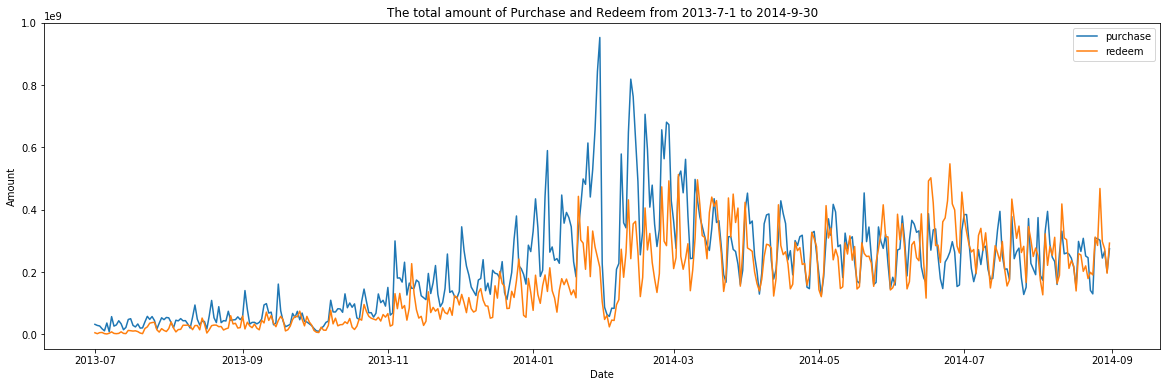

In [15]:
fig = plt.figure(figsize=(20,6))
plt.plot(total_balance['date'], total_balance['total_purchase_amt'], label='purchase')
plt.plot(total_balance['date'], total_balance['total_redeem_amt'], label='redeem')

plt.legend(loc='best')
#plt.title("The lineplot of total amount of Purchase and Redeem from July.13 to Sep.14")
plt.title("The total amount of Purchase and Redeem from 2013-7-1 to 2014-9-30")
plt.xlabel("Date")
plt.ylabel("Amount")
plt.show()

#### 画出2014年4月份以后的时间序列图

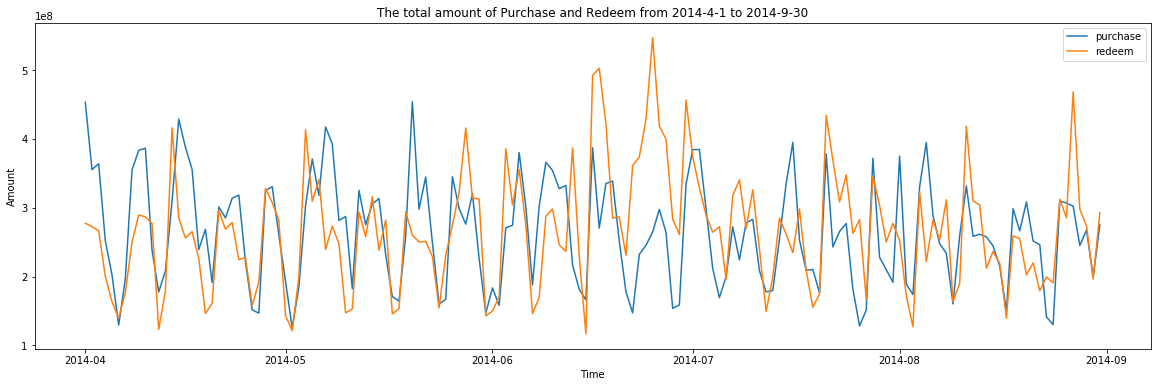

In [16]:
# 日期过滤 >=
total_balance_1 = total_balance[total_balance['date'] >= datetime.date(2014,4,1)]

fig = plt.figure(figsize=(20,6))
# 后面使用lengend方法，这里必须加 label（无法默认用列名称），不会报错，但是会警告：No handles with labels found to put in legend.
plt.plot(total_balance_1['date'], total_balance_1['total_purchase_amt'], label='purchase')
plt.plot(total_balance_1['date'], total_balance_1['total_redeem_amt'], label='redeem')
plt.legend()
#plt.title("The lineplot of total amount of Purchase and Redeem from April.14 to Sep.14")
plt.title("The total amount of Purchase and Redeem from 2014-4-1 to 2014-9-30")
plt.xlabel("Time")
plt.ylabel("Amount")
plt.show()

#### 分别画出每个月的每日购买--赎回量 的时间序列图

In [17]:
# 根据date的bool结果索引
(total_balance['date'] >= datetime.date(2014,5,1)) & (total_balance['date'] < datetime.date(2014,6,1))

0     False
1     False
2     False
3     False
4     False
      ...  
25    False
26    False
27    False
28    False
29    False
Name: date, Length: 457, dtype: bool

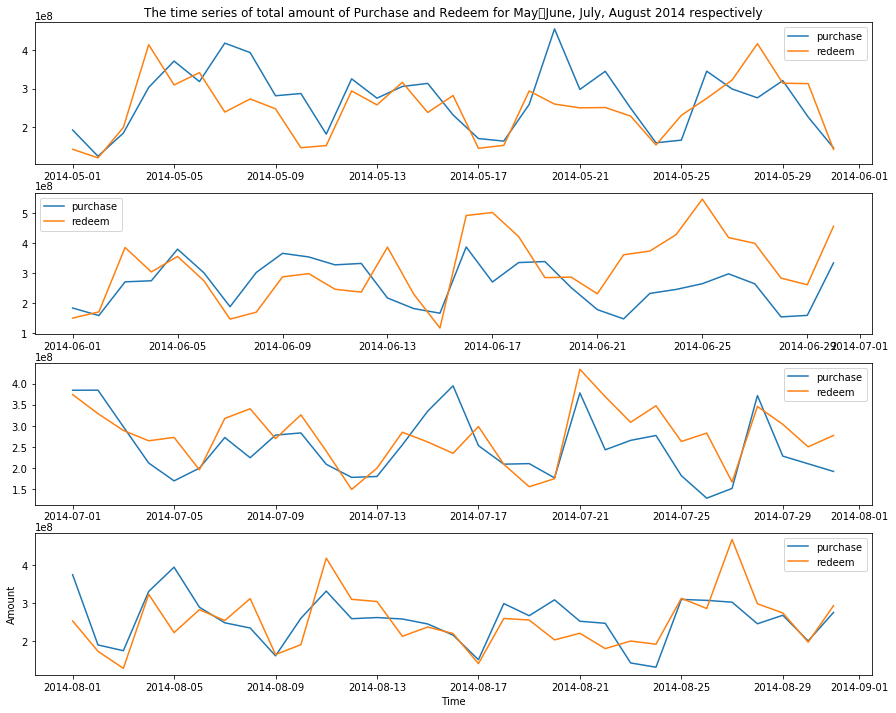

In [18]:
fig = plt.figure(figsize=(15, 12))
# plt.subplot： 4行 1列，第 i 个图
plt.subplot(4, 1, 1)
plt.title("The time series of total amount of Purchase and Redeem for May，June, July, August 2014 respectively")

# 2014年5月
total_balance_5 = total_balance[(total_balance['date'] >= datetime.date(2014,5,1)) & (total_balance['date'] < datetime.date(2014,6,1))]
plt.subplot(4,1,1)
plt.plot(total_balance_5['date'], total_balance_5['total_purchase_amt'], label='purchase')
plt.plot(total_balance_5['date'], total_balance_5['total_redeem_amt'], label='redeem')
plt.legend()

# 2014年6月
total_balance_6 = total_balance[(total_balance['date'] >= datetime.date(2014,6,1)) & (total_balance['date'] < datetime.date(2014,7,1))]
plt.subplot(4,1,2)
plt.plot(total_balance_6['date'], total_balance_6['total_purchase_amt'], label='purchase')
plt.plot(total_balance_6['date'], total_balance_6['total_redeem_amt'], label='redeem')
plt.legend()

# 2014年7月
total_balance_7 = total_balance[(total_balance['date'] >= datetime.date(2014,7,1)) & (total_balance['date'] < datetime.date(2014,8,1))]
plt.subplot(4,1,3)
plt.plot(total_balance_7['date'], total_balance_7['total_purchase_amt'], label='purchase')
plt.plot(total_balance_7['date'], total_balance_7['total_redeem_amt'], label='redeem')
plt.legend()

# 2014年8月
total_balance_8 = total_balance[(total_balance['date'] >= datetime.date(2014,8,1)) & (total_balance['date'] < datetime.date(2014,9,1))]
plt.subplot(4,1,4)
plt.plot(total_balance_8['date'], total_balance_8['total_purchase_amt'], label='purchase')
plt.plot(total_balance_8['date'], total_balance_8['total_redeem_amt'], label='redeem')
plt.legend()

plt.xlabel("Time")
plt.ylabel("Amount")
plt.show()

#### 分别画出13年8月与9月每日购买--赎回量的时序图

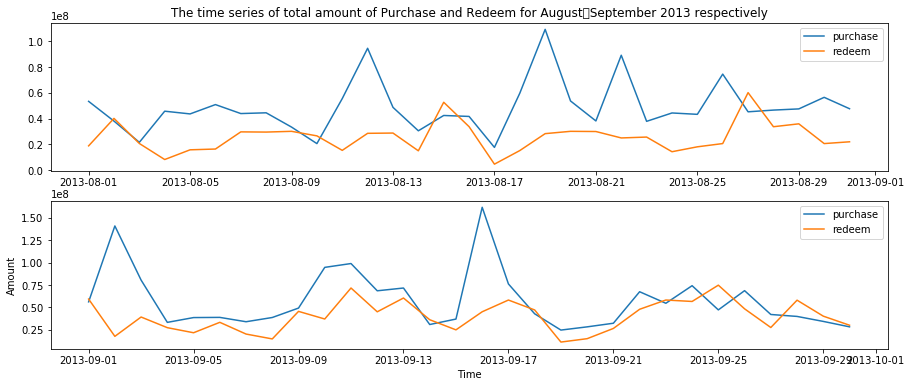

In [19]:
fig = plt.figure(figsize=(15, 6))
# plt.subplot： 2行 1列，第 i 个图
plt.subplot(2, 1, 1)
plt.title("The time series of total amount of Purchase and Redeem for August，September 2013 respectively")

# 13年8月
total_balance_last8 = total_balance[(total_balance['date'] >= datetime.date(2013,8,1)) & (total_balance['date'] < datetime.date(2013,9,1))]
plt.subplot(2,1,1)
plt.plot(total_balance_last8['date'], total_balance_last8['total_purchase_amt'], label='purchase')
plt.plot(total_balance_last8['date'], total_balance_last8['total_redeem_amt'], label='redeem')
plt.legend()

# 13年9月
total_balance_last9 = total_balance[(total_balance['date'] >= datetime.date(2013,9,1)) & (total_balance['date'] < datetime.date(2013,10,1))]
plt.subplot(2,1,2)
plt.plot(total_balance_last9['date'], total_balance_last9['total_purchase_amt'], label='purchase')
plt.plot(total_balance_last9['date'], total_balance_last9['total_redeem_amt'], label='redeem')
plt.legend()

plt.xlabel("Time")
plt.ylabel("Amount")
plt.show()

### 二、翌日特征分析

#### 每个翌日的数据分布于整体数据（2014年4月以后）的分布图

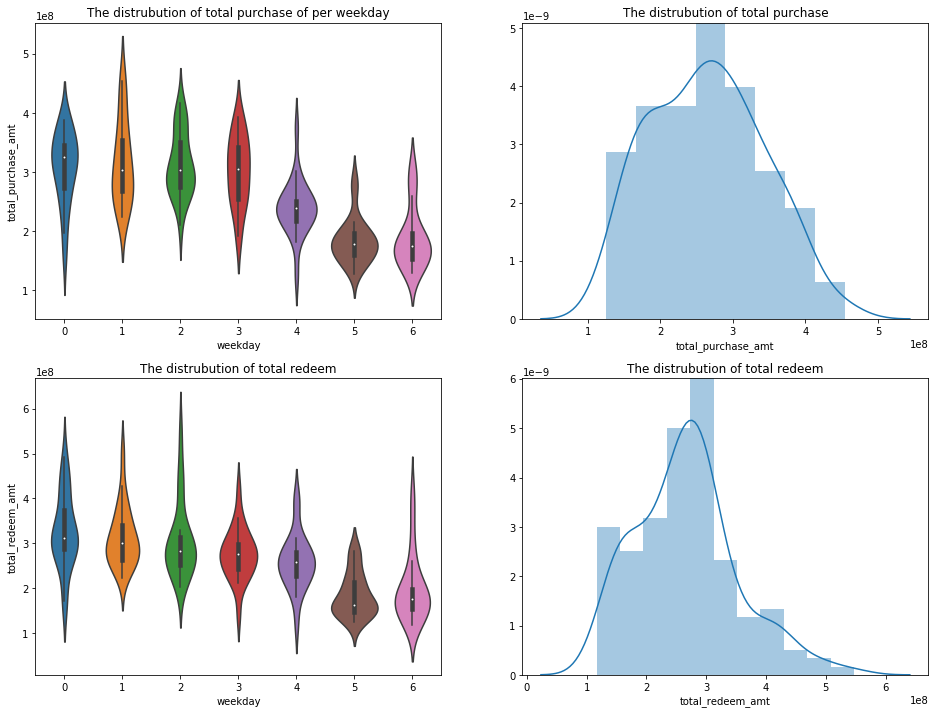

In [20]:
# plt.subplot： 2行 2列，第 i 个图
a = plt.figure(figsize=(16, 12))
scatter_para = {'marker':'.', 's':3, 'alpha':0.3}
line_kws = {'color':'k'}

# 每周每天的购买总量的箱线图情况
plt.subplot(2,2,1)
plt.title('The distrubution of total purchase of per weekday')
sns.violinplot(x='weekday', y='total_purchase_amt', data=total_balance_1, scatter_kws=scatter_para, line_kws=line_kws)

# 购买总量的总体分布情况, dropna
plt.subplot(2,2,2)
plt.title('The distrubution of total purchase')
sns.distplot(total_balance_1['total_purchase_amt'].dropna())

# 每周每天的赎回总量的箱线图情况
plt.subplot(2,2,3)
plt.title('The distrubution of total redeem')
sns.violinplot(x='weekday', y='total_redeem_amt', data = total_balance_1, scatter_kws=scatter_para, line_kws=line_kws)

# 赎回总量的总体分布情况, dropna
plt.subplot(2,2,4)
plt.title('The distrubution of total redeem')
sns.distplot(total_balance_1['total_redeem_amt'].dropna())

#### 按翌日对数据聚合后的总购买量和总赎回量取均值

In [21]:
# as_index 参数即是否将 weekday 列作为 index，否的话就相当于 reset_index 
week_sta = total_balance_1[['total_purchase_amt', 'total_redeem_amt', 'weekday']].groupby('weekday', as_index=False).mean()

In [22]:
week_sta

,weekday,total_purchase_amt,total_redeem_amt
0,0,3.075183e+08,3.268733e+08
1,1,3.173125e+08,3.138971e+08
2,2,3.133103e+08,3.076354e+08
3,3,3.019386e+08,2.763898e+08
4,4,2.398712e+08,2.591565e+08
5,5,1.837682e+08,1.855464e+08
6,6,1.884616e+08,1.980553e+08


#### 分析翌日的中位数特征（不是中位数吧，是均值情况啊？？？）

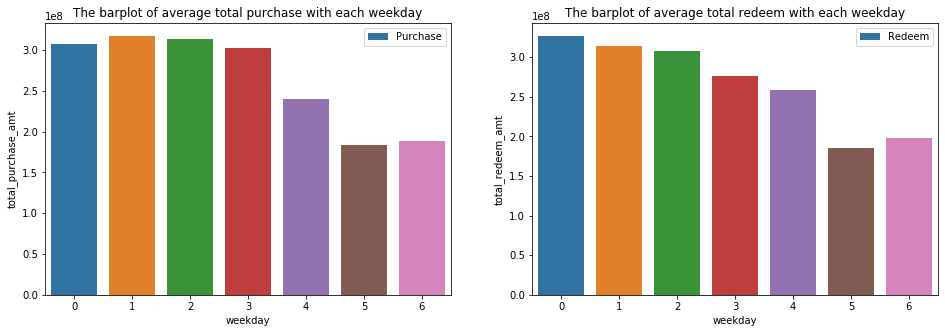

In [23]:
# plt.subplot： 1行 2列，第 i 个图
plt.figure(figsize=(16, 5))

# 赋值给 ax，子图作图
ax = plt.subplot(1,2,1)
plt.title('The barplot of average total purchase with each weekday')
ax = sns.barplot(x="weekday", y="total_purchase_amt", data=week_sta, label='Purchase')
ax.legend()

ax = plt.subplot(1,2,2)
plt.title('The barplot of average total redeem with each weekday')
ax = sns.barplot(x="weekday", y="total_redeem_amt", data=week_sta, label='Redeem')
ax.legend()

In [24]:
total_balance_1[['total_purchase_amt', 'total_redeem_amt', 'weekday']].groupby('weekday').agg(['median', 'mean']).reset_index()

weekday total_purchase_amt               total_redeem_amt              
                      median          mean           median          mean
0       0        324937272.0  3.075183e+08      312413411.0  3.268733e+08
1       1        302997322.0  3.173125e+08      300835064.0  3.138971e+08
2       2        303834661.5  3.133103e+08      282091284.5  3.076354e+08
3       3        305630866.0  3.019386e+08      275190939.0  2.763898e+08
4       4        238565132.5  2.398712e+08      257707824.5  2.591565e+08
5       5        177821764.5  1.837682e+08      163405695.0  1.855464e+08
6       6        175137350.5  1.884616e+08      176698779.0  1.980553e+08

#### 画出翌日的箱型图

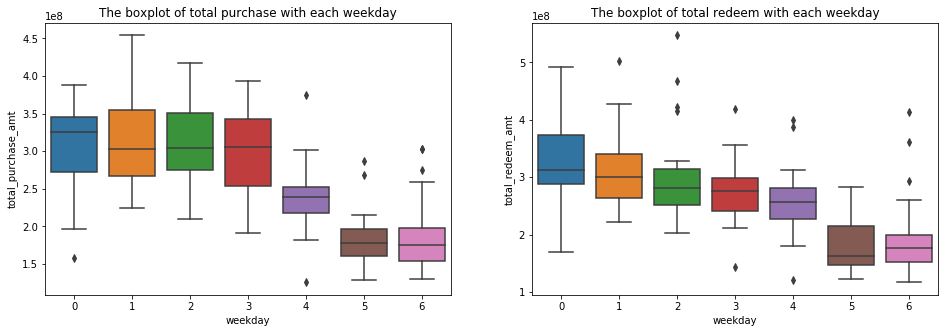

In [25]:
# plt.subplot： 1行 2列，第 i 个图
plt.figure(figsize=(16, 5))

ax = plt.subplot(1,2,1)
plt.title('The boxplot of total purchase with each weekday')
ax = sns.boxplot(x="weekday", y="total_purchase_amt", data=total_balance_1)

ax = plt.subplot(1,2,2)
plt.title('The boxplot of total redeem with each weekday')
ax = sns.boxplot(x="weekday", y="total_redeem_amt", data=total_balance_1)

#### 使用OneHot方法将翌日特征划分，获取划分后特征

In [29]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()

# 一维数组 reshape 成二维数组，符合 sklearn 的输入要求
week_feature = encoder.fit_transform( np.array(total_balance['weekday']).reshape(-1, 1) ).toarray()
# df 的七个列名是一致的，都是 weekday_onehot
week_feature = pd.DataFrame(week_feature, columns=['weekday_onehot'] * len(week_feature[0]))

# 为了pd.concat不报错
total_balance = total_balance.reset_index()
# 一个df有重复的列名称，也可以和另一个df合并；根据一个列名称 weekday_onehot，可以索引七列（名称相同）！！！
feature = pd.concat([total_balance, week_feature], axis=1)[['total_purchase_amt', 'total_redeem_amt', 'weekday_onehot', 'date']]
# 修改列名，主要是 weekday_onehot 加后缀 i 进行区分
feature.columns = list(feature.columns[0:2]) + [x + str(i) for i, x in enumerate(feature.columns[2:-1])] + ['date']

total_balance的index为 Int64Index，而week_feature的index是 RangeIndex，打印df的话看不出来区别；

所以total_balance必须reset_index，否则报错：InvalidIndexError: Reindexing only valid with uniquely valued Index objects   
https://blog.csdn.net/Ni_hao2017/article/details/95194166

In [26]:
total_balance.index

Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9,
            ...
            20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
           dtype='int64', length=457)

In [30]:
week_feature.index

RangeIndex(start=0, stop=457, step=1)

In [31]:
np.array(total_balance['weekday'][:10]).reshape(-1, 1)

array([[0],
       [1],
       [2],
       [3],
       [4],
       [5],
       [6],
       [0],
       [1],
       [2]], dtype=int64)

独热编码的效果，weekday一个特征变成了七个特征

In [32]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
encoder_test = encoder.fit_transform( np.array(total_balance['weekday'][:10]).reshape(-1, 1) ).toarray()
encoder_test

array([[1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.]])

列表的乘法，一个元素变成七个元素

In [33]:
['weekday_onehot']*len(encoder_test[0])

['weekday_onehot',
 'weekday_onehot',
 'weekday_onehot',
 'weekday_onehot',
 'weekday_onehot',
 'weekday_onehot',
 'weekday_onehot']

df的列名居然可以一致

In [34]:
aa = pd.DataFrame(encoder_test, columns=['weekday_onehot']*len(encoder_test[0]))
aa.head(3)

,weekday_onehot,weekday_onehot,weekday_onehot,weekday_onehot,weekday_onehot,weekday_onehot,weekday_onehot
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0


重复列名称不影响df合并

In [35]:
pd.concat([total_balance[:10], aa], axis=1).head(3)

,level_0,index,date,total_purchase_amt,total_redeem_amt,day,month,year,week,weekday,weekday_onehot,weekday_onehot,weekday_onehot,weekday_onehot,weekday_onehot,weekday_onehot,weekday_onehot
0,0,0,2013-07-01,32488348.0,5525022.0,1,7,2013,27,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1,2013-07-02,29037390.0,2554548.0,2,7,2013,27,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,2,2,2013-07-03,27270770.0,5953867.0,3,7,2013,27,2,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [36]:
# 可以一步代替后面的列名修改步骤
columns = [column + str(i) for i, column in enumerate(['weekday_onehot']*len(encoder_test[0]))]
columns

['weekday_onehot0',
 'weekday_onehot1',
 'weekday_onehot2',
 'weekday_onehot3',
 'weekday_onehot4',
 'weekday_onehot5',
 'weekday_onehot6']

#### 画出划分后的翌日特征与标签（总购买量、总赎回量）的斯皮尔曼相关性

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5]),
 <a list of 8 Text xticklabel objects>)

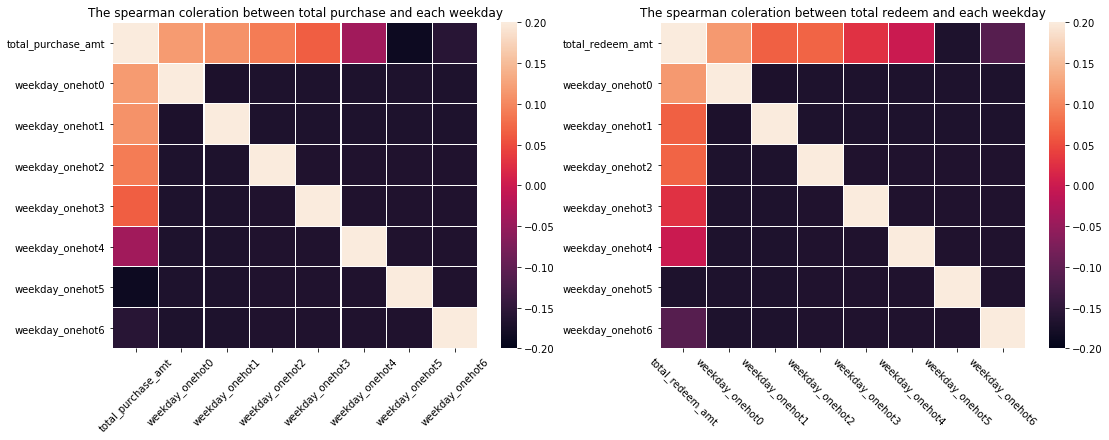

In [37]:
# plt.subplot： 1行 2列，第 i 个图
f, ax = plt.subplots(figsize=(18, 6))

plt.subplot(1,2,1)
plt.title('The spearman coleration between total purchase and each weekday')
features_without_redeem = [x for x in feature.columns if x not in ['total_redeem_amt', 'date']]
sns.heatmap(feature[features_without_redeem].corr('spearman'), linewidths=0.1, vmax=0.2, vmin=-0.2)
plt.xticks(rotation=45)

plt.subplot(1,2,2)
plt.title('The spearman coleration between total redeem and each weekday')
features_without_purchase = [x for x in feature.columns if x not in ['total_purchase_amt', 'date'] ]
sns.heatmap(feature[features_without_purchase].corr('spearman'), linewidths=0.1,  vmax=0.2, vmin=-0.2)
plt.xticks(rotation=-45)

#### 测试翌日特征与标签的独立性 Ref: https://github.com/ChuanyuXue/MVTest

In [38]:
from mvtpy.mvtest import mvtest

mv = mvtest()
mv.test(total_balance_1['total_purchase_amt'], total_balance_1['weekday'])

{'Tn': 6.75, 'p-value': [0, 0.01]}

### 三、月份特征分析

#### 画出每个月的购买总量分布估计图(kdeplot)
y轴不是占比，而是概率密度。每个柱子的面积代表概率（高度乘以宽度，该区段的概率），而不是高度；面积的和等于1。  
由于x轴的区段的取值较大，所以y轴的取值较低

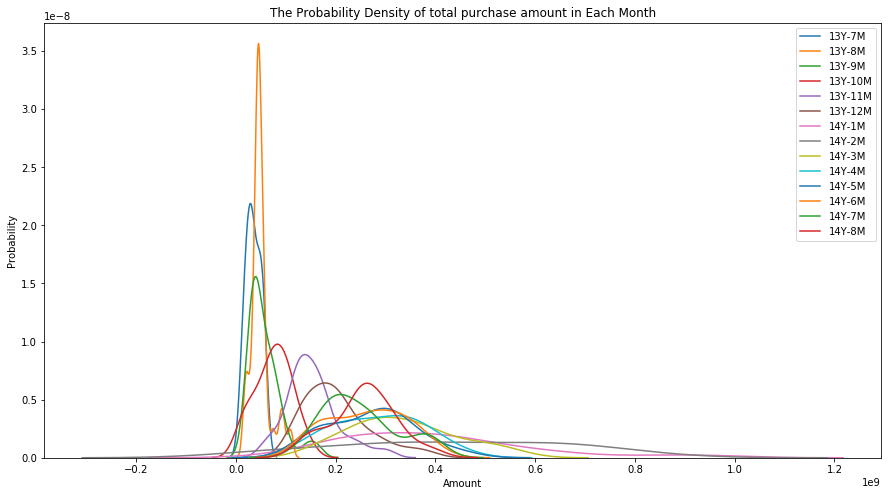

In [39]:
plt.figure(figsize=(15, 8))
plt.title('The Probability Density of total purchase amount in Each Month')
plt.ylabel('Probability')
plt.xlabel('Amount')

# 13年7-11月份
for i in range(7, 12):
    sns.kdeplot(total_balance[(total_balance['date'] >= datetime.date(2013, i, 1)) & 
                              (total_balance['date'] < datetime.date(2013, i+1, 1))]['total_purchase_amt'], label='13Y-'+ str(i) + 'M')

# 13年12月
sns.kdeplot(total_balance[(total_balance['date'] >= datetime.date(2013, 12, 1)) & 
                          (total_balance['date'] < datetime.date(2014, 1, 1))]['total_purchase_amt'], label='13Y-' + str(12) + 'M')
                                                                               
# 14年1-9月份
for i in range(1, 9):
    sns.kdeplot(total_balance[(total_balance['date'] >= datetime.date(2014, i, 1)) & 
                              (total_balance['date'] < datetime.date(2014, i+1, 1))]['total_purchase_amt'], label='14Y-' + str(i) + 'M')

#### 画出每个月的赎回总量分布估计图(kdeplot)

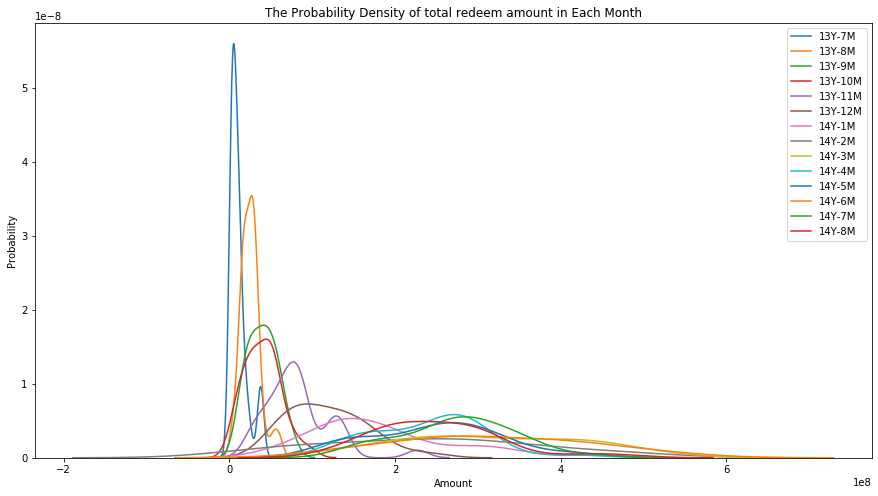

In [40]:
plt.figure(figsize=(15, 8))
plt.title('The Probability Density of total redeem amount in Each Month')
plt.ylabel('Probability')
plt.xlabel('Amount')

# 13年7-11月份
for i in range(7, 12):
    sns.kdeplot(total_balance[(total_balance['date'] >= datetime.date(2013, i, 1)) & 
                              (total_balance['date'] < datetime.date(2013, i+1, 1))]['total_redeem_amt'], label='13Y-'+ str(i) + 'M')

# 13年12月
sns.kdeplot(total_balance[(total_balance['date'] >= datetime.date(2013, 12, 1)) & 
                          (total_balance['date'] < datetime.date(2014, 1, 1))]['total_redeem_amt'], label='13Y-' + str(12) + 'M')
                                                                               
# 14年1-9月份
for i in range(1, 9):
    sns.kdeplot(total_balance[(total_balance['date'] >= datetime.date(2014, i, 1)) & 
                              (total_balance['date'] < datetime.date(2014, i+1, 1))]['total_redeem_amt'], label='14Y-' + str(i) + 'M')

#### 画出14年5--8月份的分布估计图

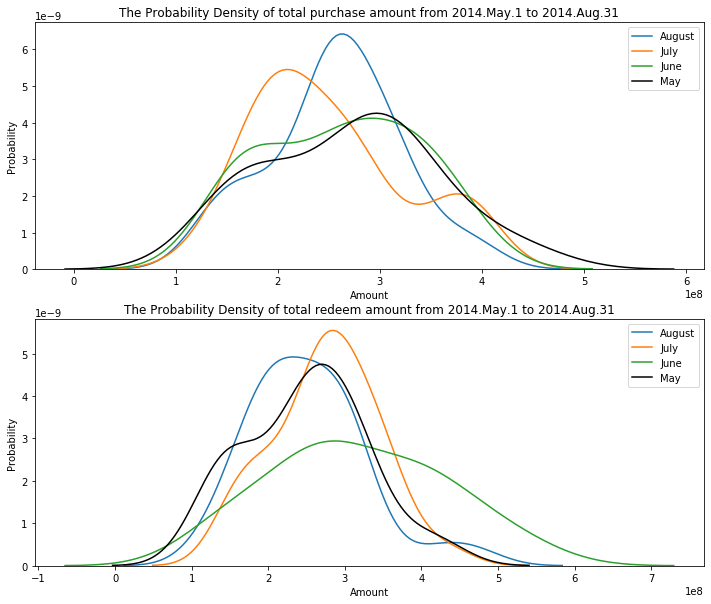

In [41]:
# plt.subplot： 2行 1列，第 i 个图
plt.figure(figsize=(12,10))

ax = plt.subplot(2, 1, 1)
plt.title('The Probability Density of total purchase amount from 2014.May.1 to 2014.Aug.31')
plt.ylabel('Probability')
plt.xlabel('Amount')
ax = sns.kdeplot(total_balance_8['total_purchase_amt'], label='August')
ax = sns.kdeplot(total_balance_7['total_purchase_amt'], label='July')
ax = sns.kdeplot(total_balance_6['total_purchase_amt'], label='June')
ax = sns.kdeplot(total_balance_5['total_purchase_amt'], color='Black', label='May')

ax = plt.subplot(2, 1, 2)
plt.title('The Probability Density of total redeem amount from 2014.May.1 to 2014.Aug.31')
plt.ylabel('Probability')
plt.xlabel('Amount')
ax = sns.kdeplot(total_balance_8['total_redeem_amt'], label='August')
ax = sns.kdeplot(total_balance_7['total_redeem_amt'], label='July')
ax = sns.kdeplot(total_balance_6['total_redeem_amt'], label='June')
ax = sns.kdeplot(total_balance_5['total_redeem_amt'], color='Black', label='May')

#### 画出13年八月到九月份的分布估计图

In [42]:
total_balance_last_7 = total_balance[(total_balance['date'] >= datetime.date(2013,7,1)) & (total_balance['date'] < datetime.date(2013,8,1))]
total_balance_last_8 = total_balance[(total_balance['date'] >= datetime.date(2013,8,1)) & (total_balance['date'] < datetime.date(2013,9,1))]
total_balance_last_9 = total_balance[(total_balance['date'] >= datetime.date(2013,9,1)) & (total_balance['date'] < datetime.date(2013,10,1))]
total_balance_last_10 = total_balance[(total_balance['date'] >= datetime.date(2013,10,1)) & (total_balance['date'] < datetime.date(2013,11,1))]

一个子图（ax）上，进行多个作图（kdeplot）

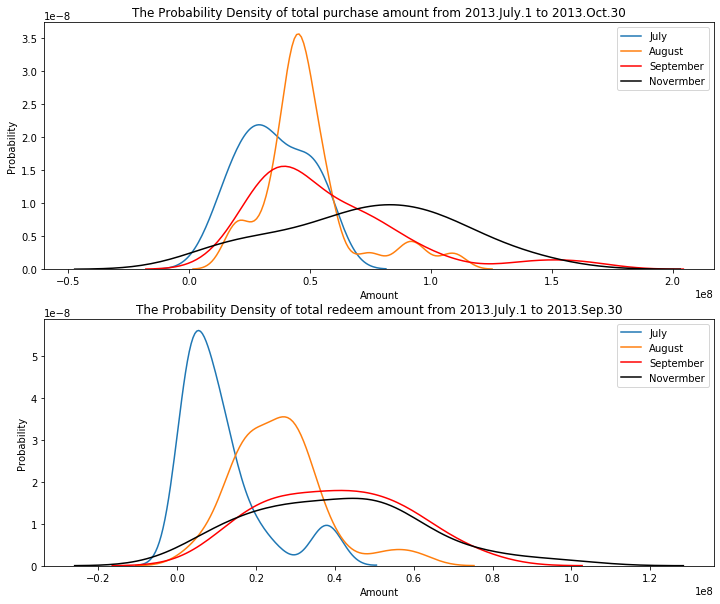

In [43]:
plt.figure(figsize=(12, 10))
ax = plt.subplot(2,1,1)
plt.title('The Probability Density of total purchase amount from 2013.July.1 to 2013.Oct.30')
plt.ylabel('Probability')
plt.xlabel('Amount')
ax = sns.kdeplot(total_balance_last_7['total_purchase_amt'], label='July')
ax = sns.kdeplot(total_balance_last_8['total_purchase_amt'], label='August')
ax = sns.kdeplot(total_balance_last_9['total_purchase_amt'], color='Red', label='September')
ax = sns.kdeplot(total_balance_last_10['total_purchase_amt'], color='Black', label='Novermber')

ax = plt.subplot(2,1,2)
plt.title('The Probability Density of total redeem amount from 2013.July.1 to 2013.Sep.30')
plt.ylabel('Probability')
plt.xlabel('Amount')
ax = sns.kdeplot(total_balance_last_7['total_redeem_amt'], label='July')
ax = sns.kdeplot(total_balance_last_8['total_redeem_amt'], label='August')
ax = sns.kdeplot(total_balance_last_9['total_redeem_amt'], color='Red', label='September')
ax = sns.kdeplot(total_balance_last_10['total_redeem_amt'], color='Black', label='Novermber')

### 四、日期特征分析

#### 按照每天聚合数据集--14年8月份

In [44]:
day_sta_8 = total_balance_8[['total_purchase_amt', 'total_redeem_amt', 'day']].groupby('day', as_index=False).mean()
# 结果是 <pandas.core.groupby.generic.DataFrameGroupBy object at 0x000001AD221CD9E8> 无法展示，加mean方法后，变成df
#day_sta_last_8 = total_balance_8[['total_purchase_amt', 'total_redeem_amt', 'day']].groupby('day', as_index=False)

#### 获取聚合后14年8月总购买和赎回量的分布柱状图

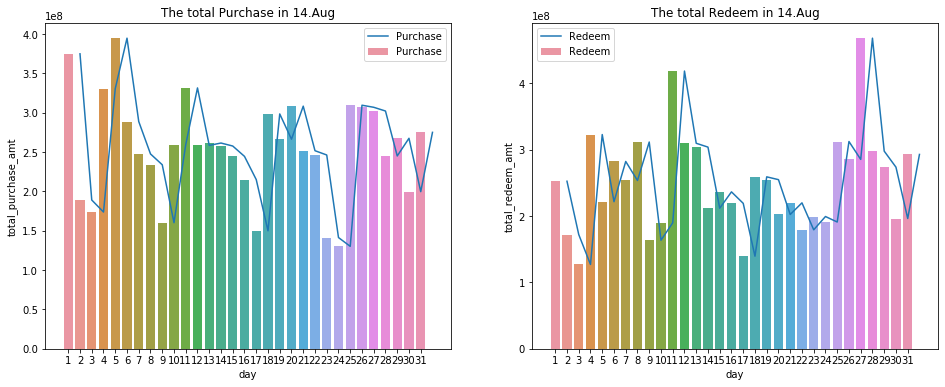

In [45]:
plt.figure(figsize=(16,6))
ax = plt.subplot(1, 2, 1)
plt.title("The total Purchase in 14.Aug")
ax = sns.barplot(x="day", y="total_purchase_amt", data=day_sta_8, label='Purchase')
ax = sns.lineplot(x="day", y="total_purchase_amt", data=day_sta_8, label='Purchase')
ax.legend()

bx = plt.subplot(1, 2, 2)
plt.title("The total Redeem in 14.Aug")
bx = sns.barplot(x="day", y="total_redeem_amt", data=day_sta_8, label='Redeem')
bx = sns.lineplot(x="day", y="total_redeem_amt", data=day_sta_8, label='Redeem')
bx.legend()

#### 获取聚合后13年9月总购买和赎回量的分布柱状图

In [46]:
day_sta_last_9 = total_balance_last_9[['total_purchase_amt', 'total_redeem_amt', 'day']].groupby('day', as_index=False).mean()

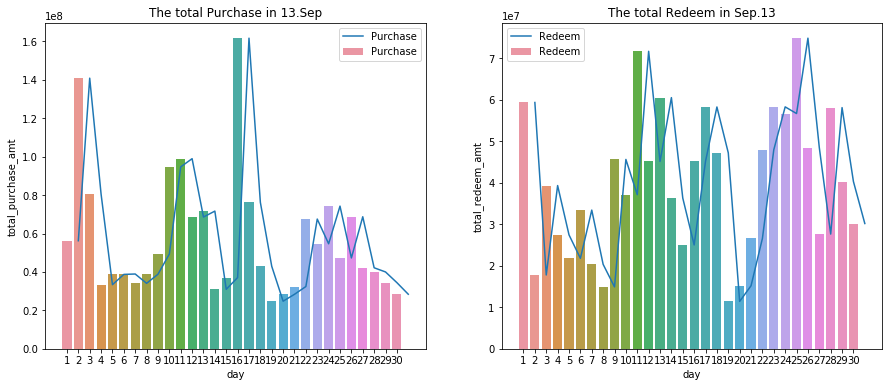

In [47]:
plt.figure(figsize=(15, 6))

plt.subplot(1,2,1)
plt.title("The total Purchase in 13.Sep")
ax = sns.barplot(x="day", y="total_purchase_amt", data=day_sta_last_9, label='Purchase')
ax = sns.lineplot(x="day", y="total_purchase_amt", data=day_sta_last_9, label='Purchase')
ax.legend()

plt.subplot(1,2,2)
plt.title("The total Redeem in Sep.13")
bx = sns.barplot(x="day", y="total_redeem_amt", data=day_sta_last_9, label='Redeem')
bx = sns.lineplot(x="day", y="total_redeem_amt", data=day_sta_last_9, label='Redeem')
bx.legend()

#### We find that the data from last year in Sep has very limited week feature

There are some strange day in Sep:

1. 1st day(Redeem is low)
2. 2nd day(Purchase is high)
3. 16th day(Purchase a lot)---Monday & 3 days before MidAutumn Festirval
4. 11th day and 25th day(Redeem a lot)---Both of Wednesday
5. 18 19 20(Both Purchase and Redeem is very low)

**图片按比例缩小**
https://blog.csdn.net/weixin_45625553/article/details/103164499
<img src="./images/1.png" style="zoom:50%" />

#### 画出历史上所有天的热力图

In [48]:
max(total_balance_1['week']),  min(total_balance_1['week'])

(40, 14)

总共27个周（编码为0-26）：14到40

In [49]:
max(total_balance_1['week']) - min(total_balance_1['week']) + 1

27

Text(87.0, 0.5, 'week')

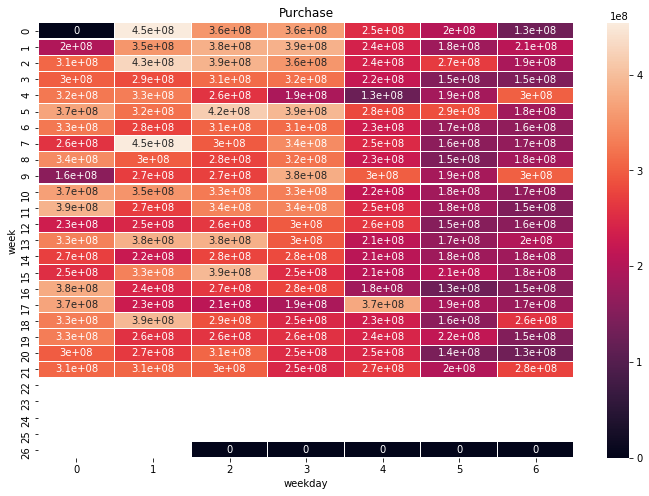

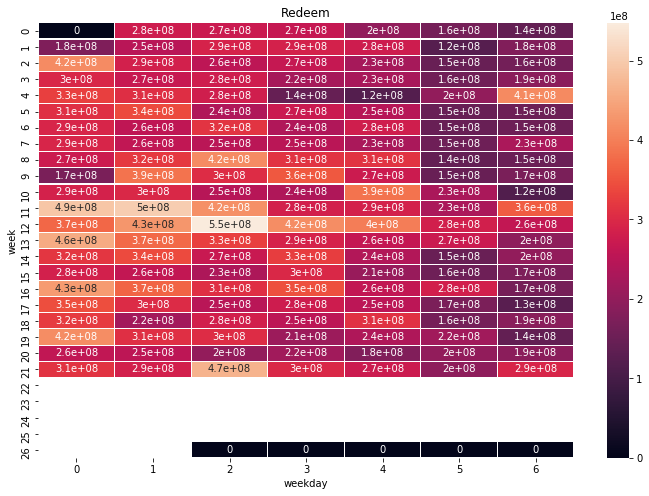

In [50]:
# purchase
test = np.zeros((max(total_balance_1['week']) - min(total_balance_1['week']) + 1, 7))
# 特殊的赋值方法：右边 series 的数值填充到左边和该数值 index 相同的位置里 ！！！！！！！！！！！！！！！！！！！！！
test[total_balance_1['week'] - min(total_balance_1['week']), total_balance_1['weekday']] = total_balance_1['total_purchase_amt']
f, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(test, linewidths=0.1, ax=ax, annot=True)
ax.set_title("Purchase")
ax.set_xlabel('weekday')
ax.set_ylabel('week')


# redeem
test = np.zeros((max(total_balance_1['week']) - min(total_balance_1['week']) + 1, 7))
test[total_balance_1['week'] - min(total_balance_1['week']), total_balance_1['weekday']] = total_balance_1['total_redeem_amt']
f, ax = plt.subplots(figsize=(12, 8))
# 27周和翌日的purchase数值用热力图显示下，越靠近上面的颜色，数值越大；  annot 标记出数值
sns.heatmap(test, linewidths=0.1, ax=ax, annot=True)
ax.set_title("Redeem")
ax.set_xlabel('weekday')
ax.set_ylabel('week')

具体是26周1天，其中第一周只有6天，最后一周只有2天，最后30天是空值nan，然后加6天，填充为27周

所以最后的 test 中，第一个值（对应week=0， weekday=0）和最后五个值（week=26， weekday=2、3、4、5、6）全是 0

In [51]:
bb = total_balance_1[['total_purchase_amt', 'week', 'weekday']]
bb['week_num'] = bb.week - min(total_balance_1.week)
print(bb.shape)
bb.head(8).append(bb.tail(5))

(183, 4)


,total_purchase_amt,week,weekday,week_num
274,453320585.0,14,1,0
275,355347118.0,14,2,0
276,363877120.0,14,3,0
277,251895894.0,14,4,0
278,202336542.0,14,5,0
279,129477254.0,14,6,0
280,196936223.0,15,0,1
281,354770149.0,15,1,1
25,NaN,39,4,25
26,NaN,39,5,25


In [52]:
test.shape,  test

((27, 7),
 array([[0.00000000e+00, 2.77429358e+08, 2.72612066e+08, 2.66605457e+08,
         2.00192637e+08, 1.63199682e+08, 1.39576683e+08],
        [1.76966561e+08, 2.50015131e+08, 2.89330278e+08, 2.86914864e+08,
         2.77077434e+08, 1.23295320e+08, 1.78934722e+08],
        [4.15986984e+08, 2.85293076e+08, 2.55914640e+08, 2.65341592e+08,
         2.25952909e+08, 1.46374940e+08, 1.61057781e+08],
        [2.95635256e+08, 2.68810141e+08, 2.78470936e+08, 2.24536754e+08,
         2.27764292e+08, 1.58122962e+08, 1.91915377e+08],
        [3.27724735e+08, 3.07578349e+08, 2.81835975e+08, 1.43362755e+08,
         1.21222064e+08, 1.99568043e+08, 4.13222034e+08],
        [3.09330781e+08, 3.41108696e+08, 2.39372999e+08, 2.73187499e+08,
         2.47743971e+08, 1.47248328e+08, 1.52945581e+08],
        [2.93952908e+08, 2.57918375e+08, 3.16225442e+08, 2.38307643e+08,
         2.82094916e+08, 1.45854372e+08, 1.53440019e+08],
        [2.93791406e+08, 2.60040720e+08, 2.50223726e+08, 2.51108485e+08,


From the heat map we find that the Redeem data of week 4--weekday 6 is very strange, and week 12--weekday 2 either
<img src="./images/2.png" style="zoom:80%" />

#### 对于 redeem 热力图中异常点（取值过高）的数据分析（1）

In [53]:
# week 4--weekday 6 的异常分析，查看具体日期---也不算很大，还有几个更大的！！！
total_balance_1[(total_balance_1['week'] == 4 + min(total_balance_1['week'])) & (total_balance_1['weekday'] == 6)]

,date,total_purchase_amt,total_redeem_amt,day,month,year,week,weekday
307,2014-05-04,303087562.0,413222034.0,4,5,2014,18,6


**2014-5-4 is a special day in China, It is the first workday after the Labour day!**
<img src="./images/3.png" style="zoom:50%" />

#### 对于 redeem 热力图中异常点（取值过高）的数据分析（2）

In [54]:
# week 12--weekday 2 的异常分析，查看具体日期
total_balance_1[(total_balance_1['week'] == 12 + min(total_balance_1['week'])) & (total_balance_1['weekday'] == 2)]

,date,total_purchase_amt,total_redeem_amt,day,month,year,week,weekday
359,2014-06-25,264663201.0,547295931.0,25,6,2014,26,2


In 2016-06-25 They Redeemed a lot but Purchase a little:应该是由于收益率下降的原因（存钱利润降低，还钱成本降低？？）
<img src="./images/4.png" style="zoom:80%" />

<img src="./images/5.png" style="zoom:60%" />

## 五、对于节假期的分析

1. The QingMing festerval (April.5 - April.7)
2. The Labour day      (May.1 - May.5)
3. The DuanWu festeval (May.31 - June.2)
4. The MidAutumn festeval (Sep.6 - Sep.8)

Others

1. Mother day(May.13)
2. Father day(June. 17)
3. TianMao 618 sales(June 10 - June 20)
4. Teachers' day(Sep 9)

#### 获取节假日的数据

In [55]:
qingming = total_balance[(total_balance['date'] >= datetime.date(2014,4,5)) & (total_balance['date'] < datetime.date(2014,4,8))]
labour = total_balance[(total_balance['date'] >= datetime.date(2014,5,1)) & (total_balance['date'] < datetime.date(2014,5,4))]
duanwu = total_balance[(total_balance['date'] >= datetime.date(2014,5,31)) & (total_balance['date'] < datetime.date(2014,6,3))]
data618 = total_balance[(total_balance['date'] >= datetime.date(2014,6,10)) & (total_balance['date'] < datetime.date(2014,6,20))]

#### 画出节假日与平时的均值

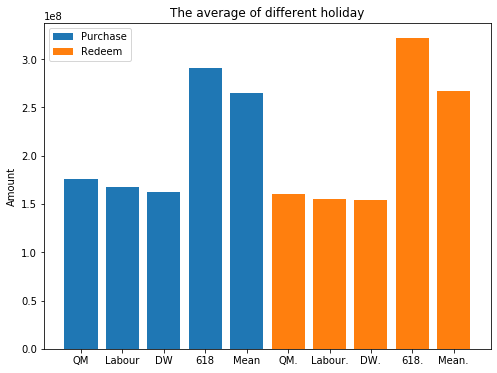

In [57]:
plt.figure(figsize=(8, 6))

# 先画总购买量
index_list = ['QM','Labour','DW','618','Mean']
label_list = [np.mean(qingming['total_purchase_amt']), np.mean(labour['total_purchase_amt']),
              np.mean(duanwu['total_purchase_amt']), np.mean(data618['total_purchase_amt']),
              np.mean(total_balance_1['total_purchase_amt'])]
plt.bar(index_list, label_list, label="Purchase")

# 再画总赎回量
index_list = ['QM.','Labour.','DW.','618.','Mean.']
label_list = [np.mean(qingming['total_redeem_amt']), np.mean(labour['total_redeem_amt']),
              np.mean(duanwu['total_redeem_amt']),np.mean(data618['total_redeem_amt']),
              np.mean(total_balance_1['total_redeem_amt'])]
plt.bar(index_list, label_list, label="Redeem")

plt.title("The average of different holiday")
plt.ylabel("Amount")
plt.legend()
plt.show()

#### 画出节假日购买量与其所处翌日的对比

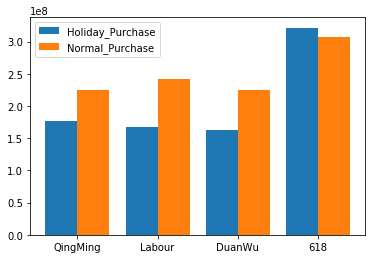

In [67]:
# 4 个柱形
size = 4
x = np.arange(size)
# 设置的 x 之间的间隔为 1，每个柱形的宽度都设置为 width，两个宽度之和不能大于 1，否则会出现覆盖现象
width = 0.4

a = [176250006, 167825284, 162844282, 321591063]
b = [225337516, 241859315, 225337516, 307635449]

# x是柱形的位置，width 是柱形的宽度，a 是要填充的数据，也是柱形的高度
plt.bar(x, a, width=width, label='Holiday_Purchase')
plt.bar(x + width, b, width=width, label='Normal_Purchase')

# 本来的刻度是刚好落在 width / 2，即第一个柱形的正中心，现在要移动到两个柱形的中间，只需移动 width / 2
plt.xticks(x + width/2, ('QingMing', 'Labour', 'DuanWu', '618'))
plt.legend()
plt.show()

#### 画出节假日赎回量与其所处翌日的对比

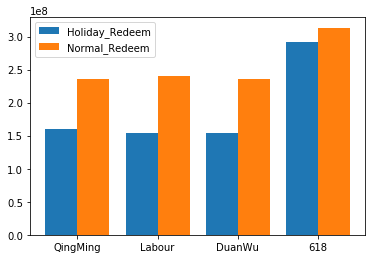

In [70]:
size = 4
x = np.arange(size)
width = 0.4

a = [159914308, 154717620, 154366940,291016763]
b = [235439685, 240364238, 235439685,313310347]

plt.bar(x, a,  width=width, label='Holiday_Redeem')
plt.bar(x + width, b, width=width, label='Normal_Redeem')

plt.xticks(x + width / 2, ('QingMing', 'Labour', 'DuanWu', '618'))
plt.legend()
plt.show()

## 六、对于节假日周边日期的分析

#### 画出清明节与周边日期的时序图

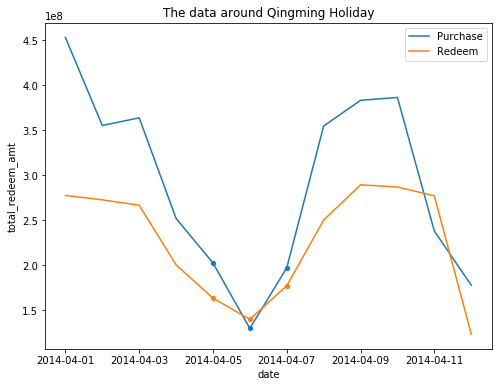

In [72]:
# 数据也包括清明节
qingming_around = total_balance[(total_balance['date'] >= datetime.date(2014,4,1)) & (total_balance['date'] < datetime.date(2014,4,13))]

# 在一张图片上多次作图，ax 参数可加可不加，ax 参数可返回，也可不返回 !!!
plt.figure(figsize=(8, 6))
sns.lineplot(x="date", y="total_purchase_amt", data=qingming_around, label='Purchase')
sns.lineplot(x="date", y="total_redeem_amt", data=qingming_around, label='Redeem')

# 单独标记出清明假期的数据, data=qingming
sns.scatterplot(x="date", y="total_purchase_amt", data=qingming)
sns.scatterplot(x="date", y="total_redeem_amt", data=qingming)

plt.title("The data around Qingming Holiday")
ax.legend()

#### 画出劳动节与周边日期的时序图

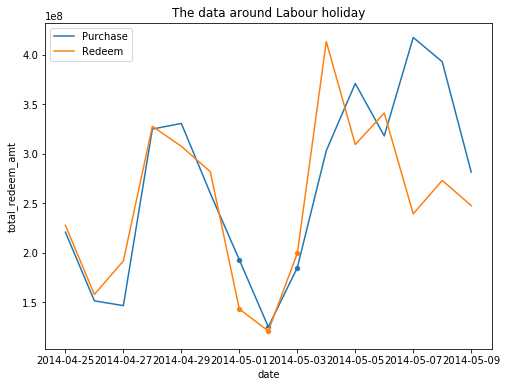

In [78]:
labour_around = total_balance[(total_balance['date'] >= datetime.date(2014,4,25)) & (total_balance['date'] < datetime.date(2014,5,10))]

# 加 ax 参数，可以不返回参数
plt.figure(figsize=(8, 6))
ax = sns.lineplot(x="date", y="total_purchase_amt", data=labour_around, label='Purchase')
ax = sns.lineplot(x="date", y="total_redeem_amt", data=labour_around, label='Redeem', ax=ax)

ax = sns.scatterplot(x="date", y="total_purchase_amt", data=labour, ax=ax)
ax = sns.scatterplot(x="date", y="total_redeem_amt", data=labour, ax=ax)

plt.title("The data around Labour holiday")
ax.legend()

#### 画出端午节与周边日期的时序图

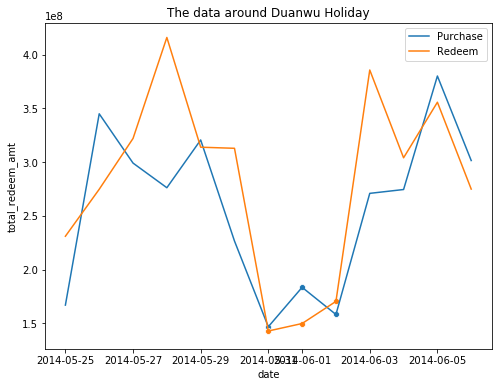

In [79]:
duanwu_around = total_balance[(total_balance['date'] >= datetime.date(2014,5,25)) & (total_balance['date'] < datetime.date(2014,6,7))]

plt.figure(figsize=(8, 6))
ax = sns.lineplot(x="date", y="total_purchase_amt", data=duanwu_around, label='Purchase')
sns.lineplot(x="date", y="total_redeem_amt", data=duanwu_around, label='Redeem', ax=ax)

ax = sns.scatterplot(x="date", y="total_purchase_amt", data=duanwu, ax=ax)
sns.scatterplot(x="date", y="total_redeem_amt", data=duanwu, ax=ax)

plt.title("The data around Duanwu Holiday")
ax.legend()

#### 画出中秋与周边日期的时序图

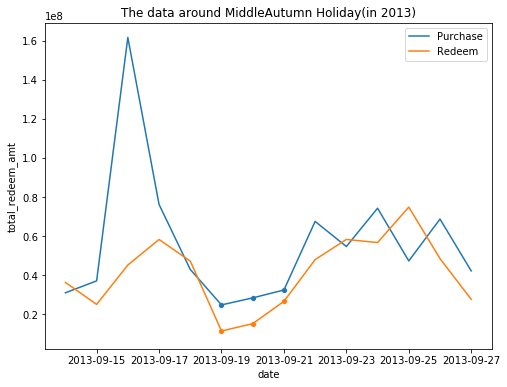

In [80]:
zhongqiu = total_balance[(total_balance['date'] >= datetime.date(2013,9,19)) & (total_balance['date'] < datetime.date(2013,9,22))]
zhongqiu_around = total_balance[(total_balance['date'] >= datetime.date(2013,9,14)) & (total_balance['date'] < datetime.date(2013,9,28))]

plt.figure(figsize=(8, 6))
ax = sns.lineplot(x="date", y="total_purchase_amt", data=zhongqiu_around, label='Purchase')
ax = sns.lineplot(x="date", y="total_redeem_amt", data=zhongqiu_around, label='Redeem', ax=ax)

ax = sns.scatterplot(x="date", y="total_purchase_amt", data=zhongqiu, ax=ax)
ax = sns.scatterplot(x="date", y="total_redeem_amt", data=zhongqiu, ax=ax)

plt.title("The data around MiddleAutumn Holiday(in 2013)")
ax.legend()

## 七、对于异常值的分析

#### 画出用户交易纪录的箱型图

In [85]:
# 分析的是原始数据
data_balance.shape

(2840421, 24)

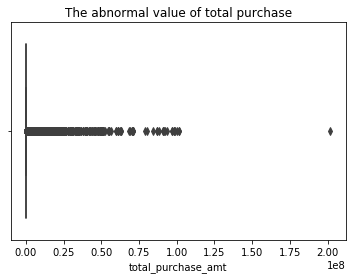

In [81]:
plt.title("The abnormal value of total purchase")
sns.boxplot(data_balance['total_purchase_amt'])

#### 分析购买总量为 2e8 的用户的交易行为

In [84]:
data_balance[data_balance.total_purchase_amt > 2e8]

,user_id,report_date,tBalance,yBalance,total_purchase_amt,direct_purchase_amt,purchase_bal_amt,purchase_bank_amt,total_redeem_amt,consume_amt,...,category1,category2,category3,category4,date,day,month,year,week,weekday
1453311,14592,20131104,99457728,0,201768328,201768328,201275171,493157,102310600,0,...,NaN,NaN,NaN,NaN,2013-11-04,4,11,2013,45,0


In [88]:
data_balance[data_balance['user_id'] == 14592].shape

(230, 24)

分析还款行为

In [92]:
data_balance[data_balance['user_id'] == 14592].sort_values(by='total_redeem_amt', axis=0, ascending=False).head(5)

,user_id,report_date,tBalance,yBalance,total_purchase_amt,direct_purchase_amt,purchase_bal_amt,purchase_bank_amt,total_redeem_amt,consume_amt,...,category1,category2,category3,category4,date,day,month,year,week,weekday
1453311,14592,20131104,99457728,0,201768328,201768328,201275171,493157,102310600,0,...,NaN,NaN,NaN,NaN,2013-11-04,4,11,2013,45,0
1453388,14592,20140616,0,98964529,1966014,1953569,0,1953569,100930543,0,...,NaN,NaN,NaN,NaN,2014-06-16,16,6,2014,25,0
1453227,14592,20131226,367063,98296082,17369,0,0,0,97946388,0,...,NaN,NaN,NaN,NaN,2013-12-26,26,12,2013,52,3
1453313,14592,20131105,97458675,99457728,4899446,4899446,4899446,0,6898499,0,...,NaN,NaN,NaN,NaN,2013-11-05,5,11,2013,45,1
1453355,14592,20140617,0,0,339679,339679,0,339679,339679,0,...,NaN,NaN,NaN,NaN,2014-06-17,17,6,2014,25,1


In [93]:
data_balance[data_balance['user_id'] == 14592].sort_values(by='total_purchase_amt', axis=0, ascending=False).head(5)

,user_id,report_date,tBalance,yBalance,total_purchase_amt,direct_purchase_amt,purchase_bal_amt,purchase_bank_amt,total_redeem_amt,consume_amt,...,category1,category2,category3,category4,date,day,month,year,week,weekday
1453311,14592,20131104,99457728,0,201768328,201768328,201275171,493157,102310600,0,...,NaN,NaN,NaN,NaN,2013-11-04,4,11,2013,45,0
1453379,14592,20140520,98653624,375218,98278406,98278357,98278357,0,0,0,...,NaN,NaN,NaN,NaN,2014-05-20,20,5,2014,21,1
1453313,14592,20131105,97458675,99457728,4899446,4899446,4899446,0,6898499,0,...,NaN,NaN,NaN,NaN,2013-11-05,5,11,2013,45,1
1453388,14592,20140616,0,98964529,1966014,1953569,0,1953569,100930543,0,...,NaN,NaN,NaN,NaN,2014-06-16,16,6,2014,25,0
1453355,14592,20140617,0,0,339679,339679,0,339679,339679,0,...,NaN,NaN,NaN,NaN,2014-06-17,17,6,2014,25,1


该用户  
`13年11月：买了2E   还了 1E
13年12月：       还了 1E
14年5月：买了0.9E
14年6月：        还了1E`

#### 画出单笔交易为 2e8 当天 (2013.11.4) 及附近几天的（所有人的）总购买量

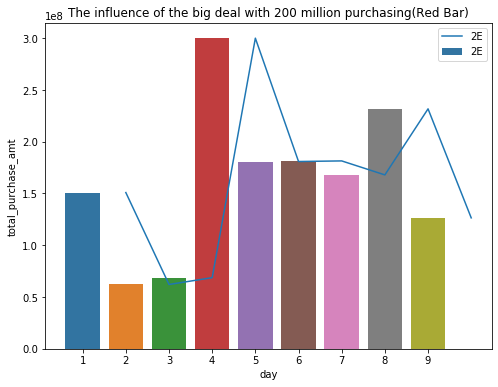

In [90]:
# 使用的是原始数据
e2_around = total_balance[(total_balance['date'] >= datetime.date(2013,11,1)) & (total_balance['date'] < datetime.date(2013,11,10))]

plt.figure(figsize=(8,6))
ax = sns.barplot(x="day", y="total_purchase_amt", data=e2_around, label='2E')
ax = sns.lineplot(x="day", y="total_purchase_amt", data=e2_around, label='2E')
plt.title("The influence of the big deal with 200 million purchasing(Red Bar)")
ax.legend()

#### 画出每日单笔最大交易的时序图

方法 size() 作用于 groupby 对象，查看每个分组有多少个数据，不同于 df 的 size 属性

In [98]:
# 每日有多笔交易（多个用户），取最大值后每个分组只剩一笔交易
data_balance[['total_purchase_amt', 'date']].groupby('date', as_index=False).size()

date
2013-07-01      441
2013-07-02      480
2013-07-03      499
2013-07-04      523
2013-07-05      544
              ...  
2014-08-27    12527
2014-08-28    12557
2014-08-29    12596
2014-08-30    12603
2014-08-31    12614
Length: 427, dtype: int64

In [99]:
data_balance[['total_purchase_amt', 'date']].groupby('date', as_index=False).max().shape

(427, 2)

Text(0.5, 1.0, 'The Biggest deal happend in each day')

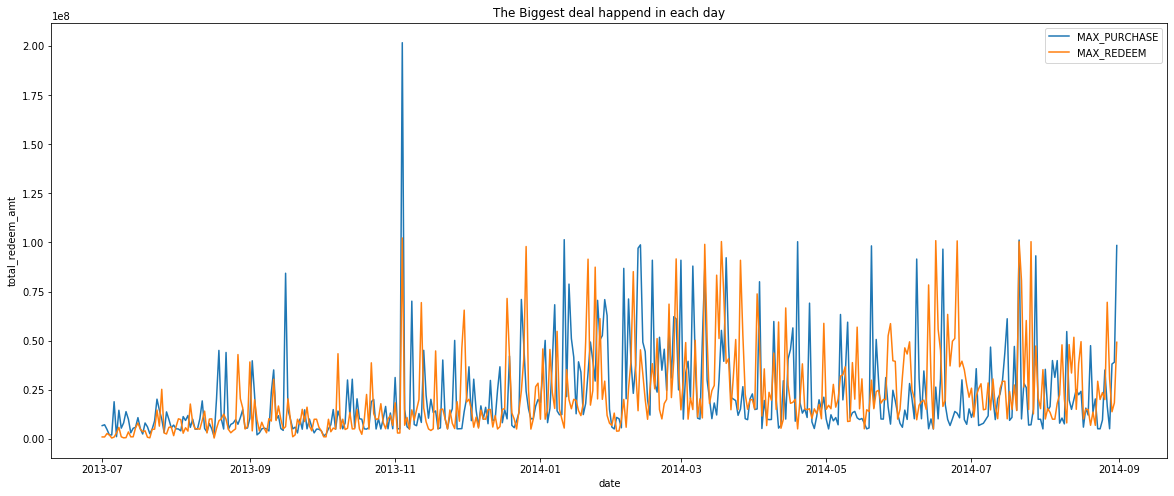

In [102]:
day_max_purchase = data_balance[['total_purchase_amt', 'date']].groupby('date', as_index=False).max()
day_max_redeem = data_balance[['total_redeem_amt', 'date']].groupby('date', as_index=False).max()

plt.figure(figsize=(20, 8))
ax = sns.lineplot(x="date", y="total_purchase_amt", data=day_max_purchase, label='MAX_PURCHASE')
ax = sns.lineplot(x="date", y="total_redeem_amt", data=day_max_redeem, label='MAX_REDEEM')
plt.title("The Biggest deal happend in each day")

#### 画出每日单笔最大交易以及总交易额的时序图

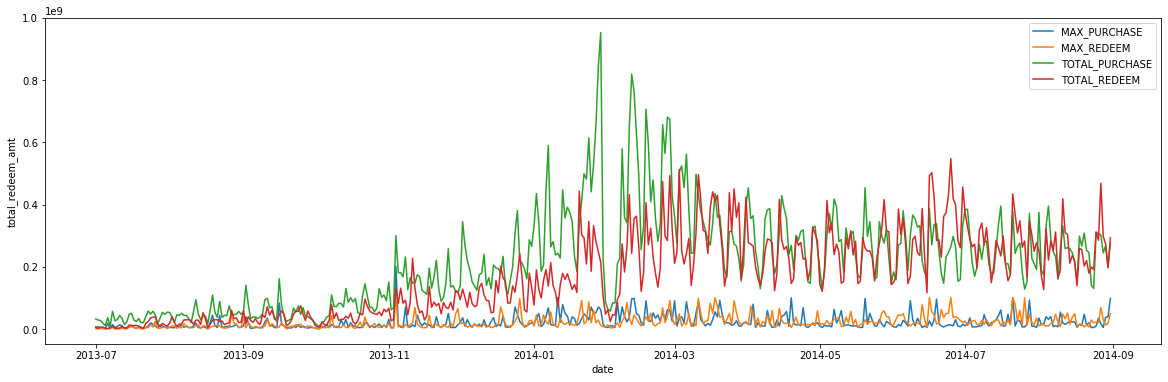

In [104]:
# 求和的结果就是前面的 total_balance，前面可以直接一次性生成每天 purchase和redeem 的 sum、max 数据
day_sum_purchase = data_balance[['total_purchase_amt', 'date']].groupby('date', as_index=False).sum()
day_sum_redeem = data_balance[['total_redeem_amt', 'date']].groupby('date', as_index=False).sum()

plt.figure(figsize=(20, 6))
ax = sns.lineplot(x="date", y="total_purchase_amt", data=day_max_purchase, label='MAX_PURCHASE')
ax = sns.lineplot(x="date", y="total_redeem_amt", data=day_max_redeem , label='MAX_REDEEM')
ax = sns.lineplot(x="date", y="total_purchase_amt", data=day_sum_purchase, label='TOTAL_PURCHASE')
ax = sns.lineplot(x="date", y="total_redeem_amt", data=day_sum_redeem, label='TOTAL_REDEEM')

In [105]:
day_sum_purchase.head()

,date,total_purchase_amt
0,2013-07-01,32488348
1,2013-07-02,29037390
2,2013-07-03,27270770
3,2013-07-04,18321185
4,2013-07-05,11648749


In [103]:
total_balance.head()

,level_0,index,date,total_purchase_amt,total_redeem_amt,day,month,year,week,weekday
0,0,0,2013-07-01,32488348.0,5525022.0,1,7,2013,27,0
1,1,1,2013-07-02,29037390.0,2554548.0,2,7,2013,27,1
2,2,2,2013-07-03,27270770.0,5953867.0,3,7,2013,27,2
3,3,3,2013-07-04,18321185.0,6410729.0,4,7,2013,27,3
4,4,4,2013-07-05,11648749.0,2763587.0,5,7,2013,27,4


#### 画出每个月大额交易的频次直方图

In [107]:
1e7 == 10000000

True

在多重分组（相当于多重 index）下，方法 count() 统计每个分组方式有多少个数据，相当于 groupby 对象的 size() 方法

In [108]:
data_balance[(data_balance['total_purchase_amt'] > 1e7) | 
             (data_balance['total_redeem_amt'] > 1e7)][['month','year','user_id']].groupby(['year','month'], as_index=False).size()

year  month
2013  7          9
      8         26
      9         27
      10        27
      11        51
      12        83
2014  1        224
      2        241
      3        240
      4        115
      5        143
      6        157
      7        126
      8        101
dtype: int64

user_id 其实表示的是**用户的数量**

In [109]:
data_balance[(data_balance['total_purchase_amt'] > 1e7) | 
             (data_balance['total_redeem_amt'] > 1e7)][['month','year','user_id']].groupby(['year','month'], as_index=False).count()

,year,month,user_id
0,2013,7,9
1,2013,8,26
2,2013,9,27
3,2013,10,27
4,2013,11,51
5,2013,12,83
6,2014,1,224
7,2014,2,241
8,2014,3,240
9,2014,4,115


Text(0.5, 1.0, 'The frequency of super big deal(larger than 10 million) in each month')

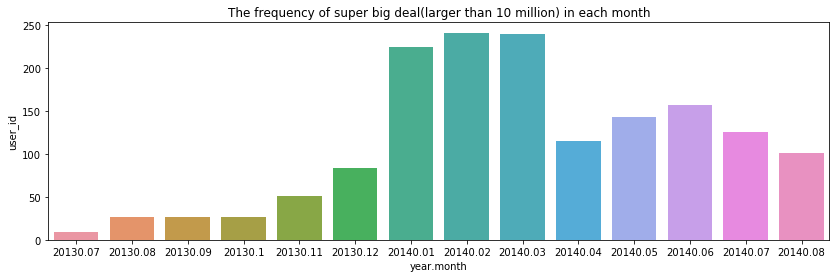

In [132]:
# 总购买量以及总赎回量均大于 1e7
big_frequancy = data_balance[(data_balance['total_purchase_amt'] > 1e7) | (data_balance['total_redeem_amt'] > 1e7)
                            ][['month','year','user_id']].groupby(['year','month'], as_index=False).count()

# 通过函数生成新的特征，字符串的拼接
big_frequancy['year.month'] = big_frequancy['year'].apply(str) + big_frequancy['month'].map(lambda x: str(x/100))

plt.figure(figsize=(14, 4))
ax = sns.barplot(x="year.month", y="user_id", data=big_frequancy)
plt.title("The frequency of super big deal(larger than 10 million) in each month")

必须把月份除以100，保证占位数一致(直接拼接的话，有的月份占两位，有的占一位)，不然绘图时，**日期的排列会错位**

In [127]:
big_frequancy['year'].apply(lambda x: str(x).strip()) + '.'+ big_frequancy['month'].map(lambda x: str(x).strip())

0      2013.7
1      2013.8
2      2013.9
3     2013.10
4     2013.11
5     2013.12
6      2014.1
7      2014.2
8      2014.3
9      2014.4
10     2014.5
11     2014.6
12     2014.7
13     2014.8
dtype: object

#### 获取大额交易（purchase或者redeem 大于 1e6）的数据集

In [134]:
# 先在 df 中创建一个空的 series，再修改数值
data_balance['big_purchase'] = 0
# 针对原始数据中的每笔交易进行过滤
data_balance.loc[data_balance['total_purchase_amt'] > 1e6, 'big_purchase'] = 1

data_balance['big_redeem'] = 0
data_balance.loc[data_balance['total_redeem_amt'] > 1e6, 'big_redeem'] = 1

#### 对大额交易按每天做聚合操作

In [135]:
# 统计每天 所有大额purchase（大于 1e6） 的总量
big_purchase = data_balance[data_balance['big_purchase'] == 1].groupby(['date'], as_index=False)['total_purchase_amt'].sum()
# 统计每天 所有大额redeem（大于 1e6） 的总量
big_redeem = data_balance[data_balance['big_redeem'] == 1].groupby(['date'], as_index=False)['total_redeem_amt'].sum()

# 统计 小额交易的 每天交易总量
small_purchase = data_balance[data_balance['big_purchase'] == 0].groupby(['date'], as_index=False)['total_purchase_amt'].sum()
small_redeem = data_balance[data_balance['big_redeem'] == 0].
groupby(['date'], as_index=False)['total_redeem_amt'].sum()

#### 画出每天 大额交易总量与小额交易总量 的时序分布图

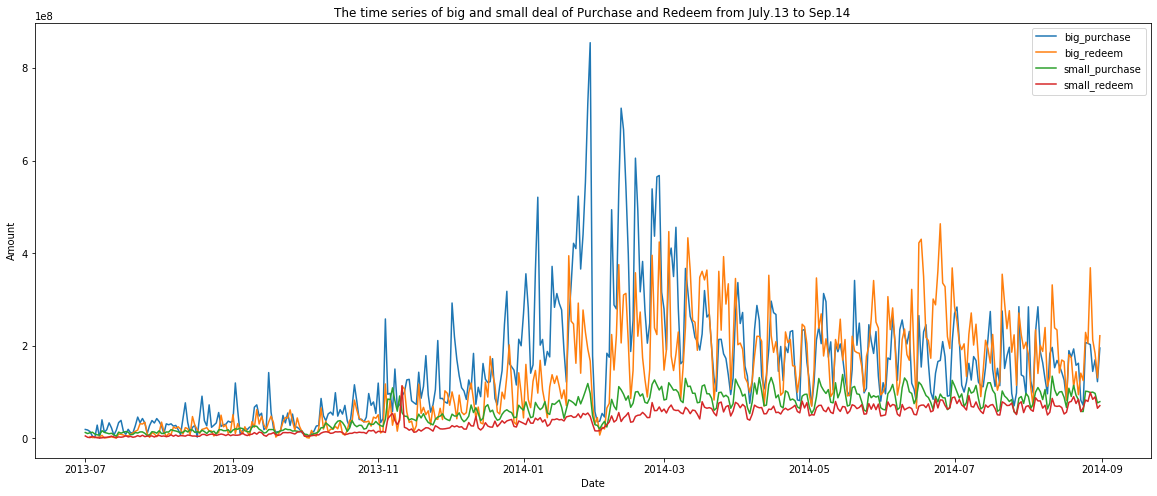

In [136]:
fig = plt.figure(figsize=(20, 8))
plt.title("The time series of big and small deal of Purchase and Redeem from July.13 to Sep.14")

# 大额交易
plt.plot(big_purchase['date'], big_purchase['total_purchase_amt'], label='big_purchase')
plt.plot(big_redeem['date'], big_redeem['total_redeem_amt'], label='big_redeem')

# 小额交易
plt.plot(small_purchase['date'], small_purchase['total_purchase_amt'], label='small_purchase')
plt.plot(small_redeem['date'], small_redeem['total_redeem_amt'], label='small_redeem')

plt.legend(loc='best')
plt.xlabel("Date")
plt.ylabel("Amount")
plt.show()

#### 每日（2014年4月---8月）大额交易总额与小额交易总额的分布估计图

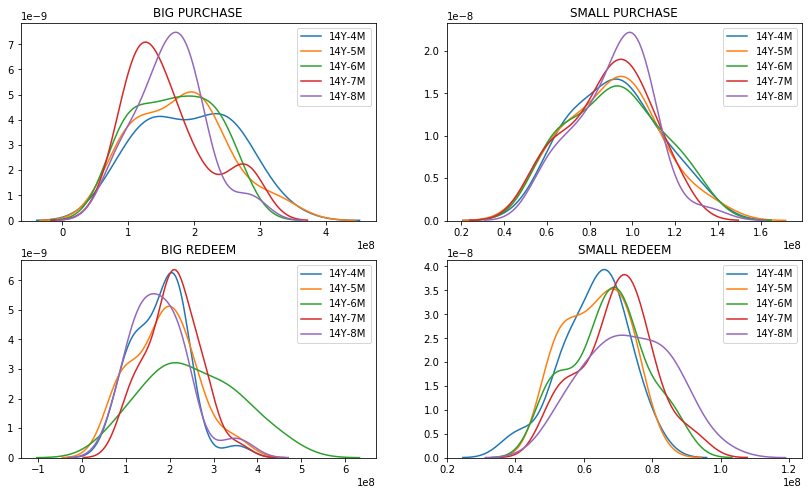

In [141]:
plt.figure(figsize=(14, 8))

plt.subplot(2,2,1)
plt.title('BIG PURCHASE')
for i in range(4, 9):
    sns.kdeplot(big_purchase[(big_purchase['date'] >= datetime.date(2014,i,1)) & 
                             (big_purchase['date'] < datetime.date(2014,i+1,1))]['total_purchase_amt'], label='14Y-' +str(i)+ 'M')

plt.subplot(2,2,2)
plt.title('SMALL PURCHASE')
for i in range(4, 9):
    sns.kdeplot(small_purchase[(small_purchase['date'] >= datetime.date(2014,i,1)) & 
                               (small_purchase['date'] < datetime.date(2014,i+1,1))]['total_purchase_amt'], label='14Y-' +str(i)+ 'M')

plt.subplot(2,2,3)
plt.title('BIG REDEEM')
for i in range(4, 9):
    sns.kdeplot(big_redeem[(big_redeem['date'] >= datetime.date(2014,i,1)) & 
                           (big_redeem['date'] < datetime.date(2014,i+1,1))]['total_redeem_amt'], label='14Y-' +str(i)+ 'M')

plt.subplot(2,2,4)
plt.title('SMALL REDEEM')
for i in range(4, 9):
    sns.kdeplot(small_redeem[(small_redeem['date'] >= datetime.date(2014,i,1)) & 
                             (small_redeem['date'] < datetime.date(2014,i+1,1))]['total_redeem_amt'], label='14Y-' +str(i)+ 'M')

#### 大小交易量数据添加时间戳（翌日）

In [145]:
big_purchase['weekday'] = big_purchase['date'].dt.weekday
small_purchase['weekday'] = small_purchase['date'].dt.weekday
big_redeem['weekday'] = big_redeem['date'].dt.weekday
small_redeem['weekday'] = small_redeem['date'].dt.weekday

#### 分析大额小额交易量的（2014年4月---8月）翌日分布

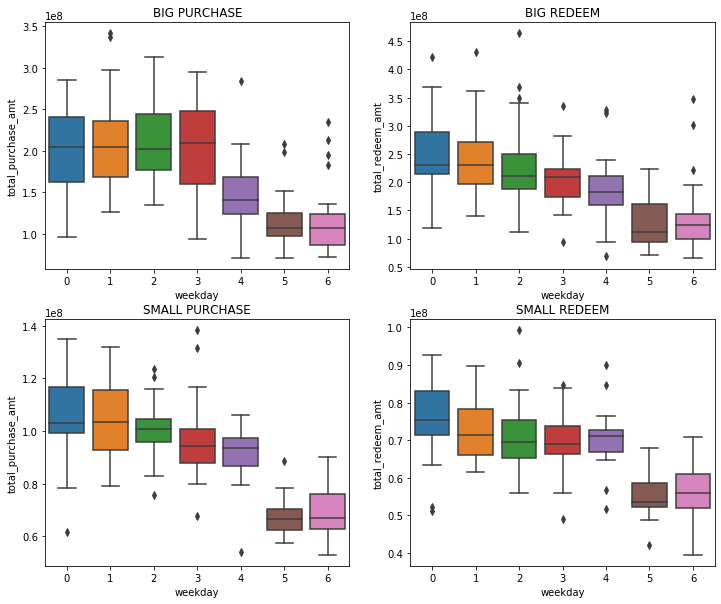

In [148]:
plt.figure(figsize=(12, 10))

ax = plt.subplot(2,2,1)
plt.title('BIG PURCHASE')
ax = sns.boxplot(x="weekday", y="total_purchase_amt", data=big_purchase[big_purchase['date'] >= datetime.date(2014,4,1)])

ax = plt.subplot(2,2,2)
plt.title('BIG REDEEM')
ax = sns.boxplot(x="weekday", y="total_redeem_amt", data=big_redeem[big_redeem['date'] >= datetime.date(2014,4,1)])

ax = plt.subplot(2,2,3)
plt.title('SMALL PURCHASE')
ax = sns.boxplot(x="weekday", y="total_purchase_amt", data=small_purchase[small_purchase['date'] >= datetime.date(2014,4,1)])

ax = plt.subplot(2,2,4)
plt.title('SMALL REDEEM')
ax = sns.boxplot(x="weekday", y="total_redeem_amt", data=small_redeem[small_redeem['date'] >= datetime.date(2014,4,1)])

## 八、分析用户交易纪录表中其他变量

#### 截断数据集（2014年4月---8月）

In [149]:
data_balance_1 = data_balance[data_balance['date'] > datetime.datetime(2014,4,1)]

In [151]:
data_balance_1.shape

(1725326, 26)

In [150]:
data_balance_1.columns

Index(['user_id', 'report_date', 'tBalance', 'yBalance', 'total_purchase_amt',
       'direct_purchase_amt', 'purchase_bal_amt', 'purchase_bank_amt',
       'total_redeem_amt', 'consume_amt', 'transfer_amt', 'tftobal_amt',
       'tftocard_amt', 'share_amt', 'category1', 'category2', 'category3',
       'category4', 'date', 'day', 'month', 'year', 'week', 'weekday',
       'big_purchase', 'big_redeem'],
      dtype='object')

#### 用户交易纪录表中其他变量与标签（total_purchase_amt、total_redeem_amt）的相关系数图

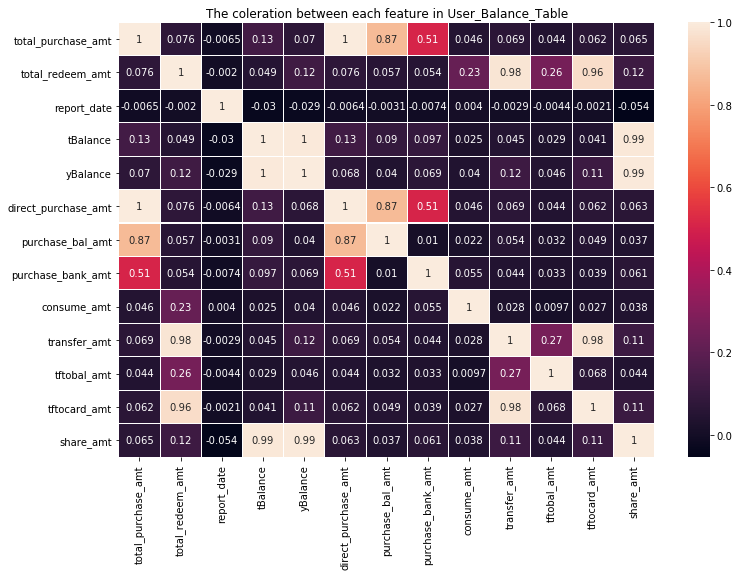

In [156]:
# 下面这些特征不计算： 'user_id', 'category1', 'category2', 'category3', 'category4', 'date', 'day', 'month', 
# 'year', 'week', 'weekday', 'big_purchase', 'big_redeem'
features_for_corr = ['total_purchase_amt','total_redeem_amt', 'report_date', 'tBalance', 'yBalance', 'direct_purchase_amt',
           'purchase_bal_amt', 'purchase_bank_amt', 'consume_amt', 'transfer_amt', 'tftobal_amt', 'tftocard_amt', 'share_amt']

plt.figure(figsize=(12, 8))
plt.title("The coleration between each feature in User_Balance_Table")
sns.heatmap(data_balance_1[features_for_corr].corr(), linewidths=0.05, annot=True)   

## 九、对于银行及支付宝利率的分析

#### 读取银行利率数据并添加时间戳

In [164]:
bank = pd.read_csv(dataset_path + "mfd_bank_shibor.csv")

In [165]:
bank.shape

(294, 9)

In [166]:
bank.head()

,mfd_date,Interest_O_N,Interest_1_W,Interest_2_W,Interest_1_M,Interest_3_M,Interest_6_M,Interest_9_M,Interest_1_Y
0,20130701,4.456,5.423,6.040,6.8800,5.295,4.2390,4.2820,4.4125
1,20130702,3.786,4.750,5.074,5.8000,5.211,4.2344,4.2808,4.4070
2,20130703,3.400,4.242,4.658,5.2000,5.148,4.2300,4.2796,4.4022
3,20130704,3.348,3.938,4.464,5.1020,5.029,4.2287,4.2776,4.4000
4,20130705,3.380,3.816,4.295,4.7885,4.939,4.2273,4.2749,4.4000


In [167]:
bank = bank.rename(columns = {'mfd_date': 'date'})
bank['date'] = pd.to_datetime(bank['date'], format="%Y%m%d")

bank_features = [x for x in bank.columns if x not in ['date']]

bank['day'] = bank['date'].dt.day
bank['month'] = bank['date'].dt.month
bank['year'] = bank['date'].dt.year
bank['week'] = bank['date'].dt.week
bank['weekday'] = bank['date'].dt.weekday

#### 读取支付宝利率数据并添加时间戳

In [168]:
share = pd.read_csv(dataset_path + 'mfd_day_share_interest.csv')

In [169]:
share.shape

(427, 3)

In [170]:
share.head()

,mfd_date,mfd_daily_yield,mfd_7daily_yield
0,20130701,1.5787,6.307
1,20130702,1.5461,6.174
2,20130703,1.4670,6.034
3,20130704,1.4223,5.903
4,20130705,1.3845,5.739


In [171]:
share = share.rename(columns = {'mfd_date': 'date'})
share['date'] = pd.to_datetime(share['date'], format="%Y%m%d")

share_features = [x for x in share.columns if x not in ['date']]

share['day'] = share['date'].dt.day
share['month'] = share['date'].dt.month
share['year'] = share['date'].dt.year
share['week'] = share['date'].dt.week
share['weekday'] = share['date'].dt.weekday

#### 前一天的银行及支付宝利率 与 标签（purchase、redeem）的相关系数图

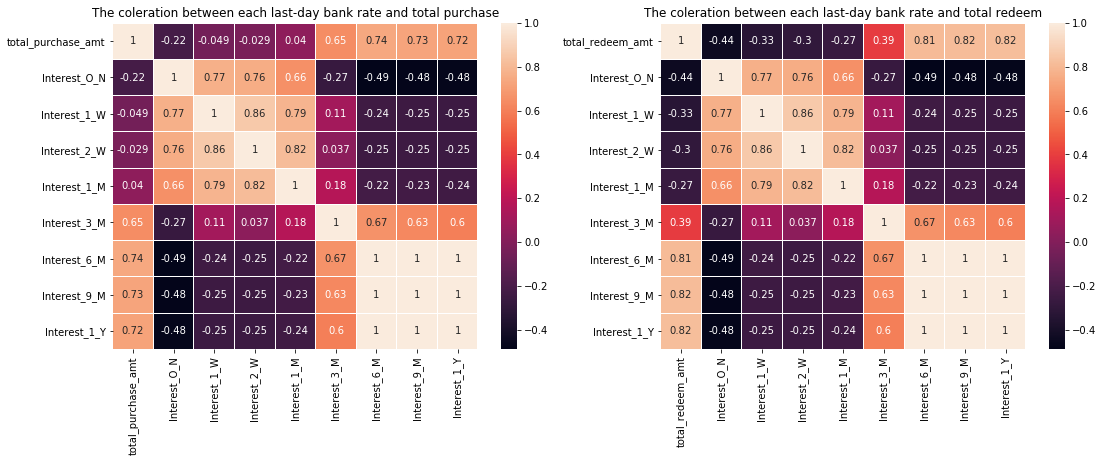

In [189]:
# 比如 bank 的日期 2013.7.1 现在变为 2013.7.2，然后对照total_balance 的 2013.7.2
bank['last_date'] = bank['date'] + datetime.timedelta(days=1)

plt.figure(figsize=(18, 6))
plt.subplot(1,2,1)
plt.title("The coleration between each last-day bank rate and total purchase")
# 分别对照 bank 的 last_date，total_balance 的 date 进行数据合并
bank_purchase_day = pd.merge(bank[['last_date'] + bank_features], total_balance, 
                left_on='last_date', right_on='date')[['total_purchase_amt'] + bank_features]
sns.heatmap(bank_purchase_day.corr(), linewidths=0.05, annot=True) 

plt.subplot(1,2,2)
plt.title("The coleration between each last-day bank rate and total redeem")
bank_redeem_day = pd.merge(bank[['last_date'] + bank_features], total_balance, 
                left_on='last_date', right_on='date')[['total_redeem_amt'] + bank_features]
sns.heatmap(bank_redeem_day.corr(), linewidths=0.05, annot=True)  

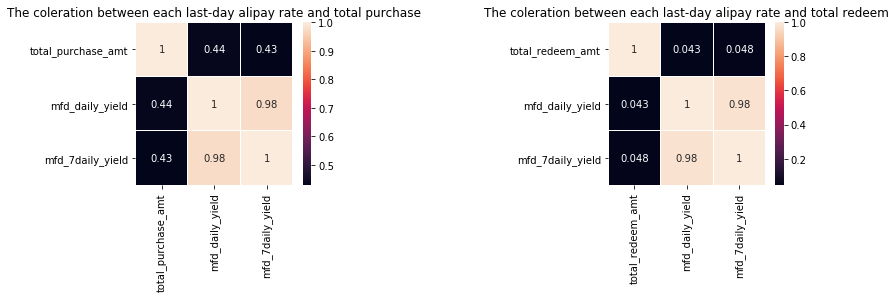

In [184]:
share['last_date'] = share['date'] + datetime.timedelta(days=1)

plt.figure(figsize=(12, 3))
# 三个图，中间的不绘制，用作空格
plt.subplot(1,3,1)
plt.title("The coleration between each last-day alipay rate and total purchase")
# 分别对照 bank 的 last_date，total_balance 的 date 进行数据合并
alipay_purchase = pd.merge(share[['last_date'] + share_features], total_balance, 
                left_on='last_date', right_on='date')[['total_purchase_amt'] + share_features]
sns.heatmap(alipay_purchase.corr(), linewidths=0.05, annot=True) 

plt.subplot(1,3,3)
plt.title("The coleration between each last-day alipay rate and total redeem")
alipay_redeem = pd.merge(share[['last_date'] + share_features], total_balance, 
                left_on='last_date', right_on='date')[['total_redeem_amt'] + share_features]
sns.heatmap(alipay_redeem.corr(), linewidths=0.05, annot=True)  

#### 上一星期的银行及支付宝利率 与标签（purchase、redeem）的相关性图

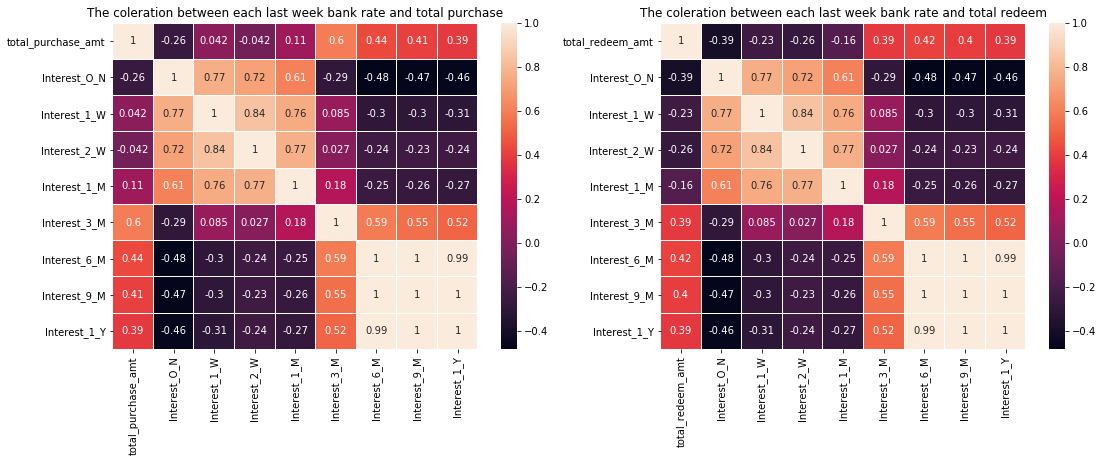

In [185]:
bank['last_week'] = bank['week'] + 1

plt.figure(figsize=(18, 6))
plt.subplot(1,2,1)
plt.title("The coleration between each last week bank rate and total purchase")
# 提前一星期，翌日也要对应
bank_purchase_week = pd.merge(bank[['last_week','weekday'] + bank_features], total_balance, 
                              left_on=['last_week','weekday'], right_on=['week','weekday'])[['total_purchase_amt'] + bank_features]
sns.heatmap(bank_purchase_week.corr(), linewidths=0.05, annot=True) 

plt.subplot(1,2,2)
plt.title("The coleration between each last week bank rate and total redeem")
bank_redeem_week = pd.merge(bank[['last_week','weekday'] + bank_features], total_balance, 
                            left_on=['last_week','weekday'], right_on=['week','weekday'])[['total_redeem_amt'] + bank_features]
sns.heatmap(bank_redeem_week.corr(), linewidths=0.05, annot=True) 

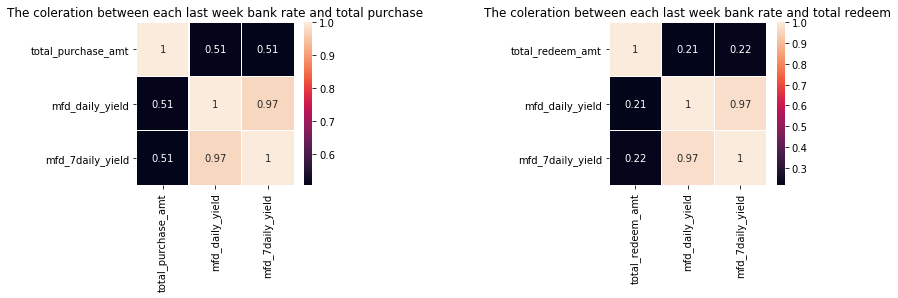

In [187]:
share['last_week'] = share['week'] + 1

plt.figure(figsize=(12, 3))
plt.subplot(1,3,1)
plt.title("The coleration between each last week bank rate and total purchase")
alipay_purchase_week = pd.merge(share[['last_week','weekday'] + share_features], total_balance, 
                              left_on=['last_week','weekday'], right_on=['week','weekday'])[['total_purchase_amt'] + share_features]
sns.heatmap(alipay_purchase_week.corr(), linewidths=0.05, annot=True) 

plt.subplot(1,3,3)
plt.title("The coleration between each last week bank rate and total redeem")
alipay_redeem_week = pd.merge(share[['last_week','weekday'] + share_features], total_balance, 
                            left_on=['last_week','weekday'], right_on=['week','weekday'])[['total_redeem_amt'] + share_features]
sns.heatmap(alipay_redeem_week.corr(), linewidths=0.05, annot=True) 

#### 前一天的银行利率 与 大额小额交易量数据的相关系数图

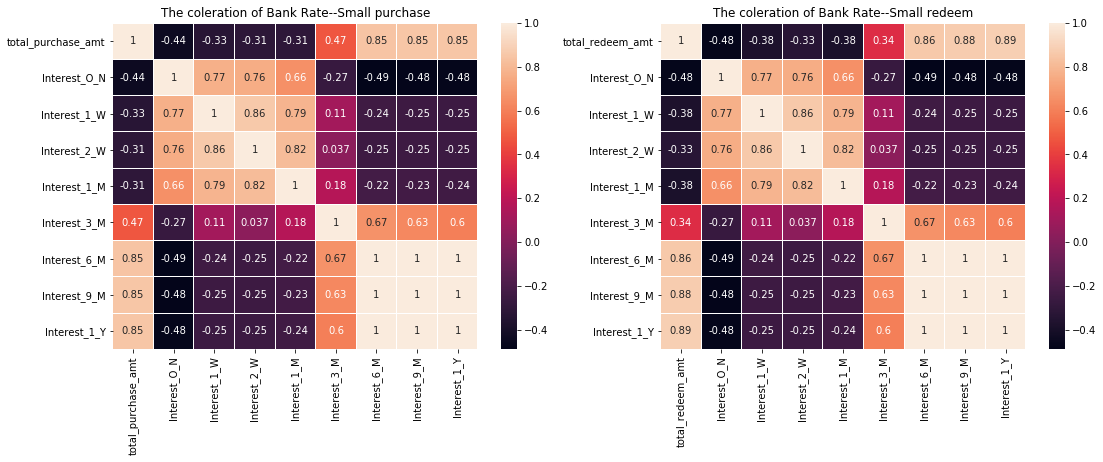

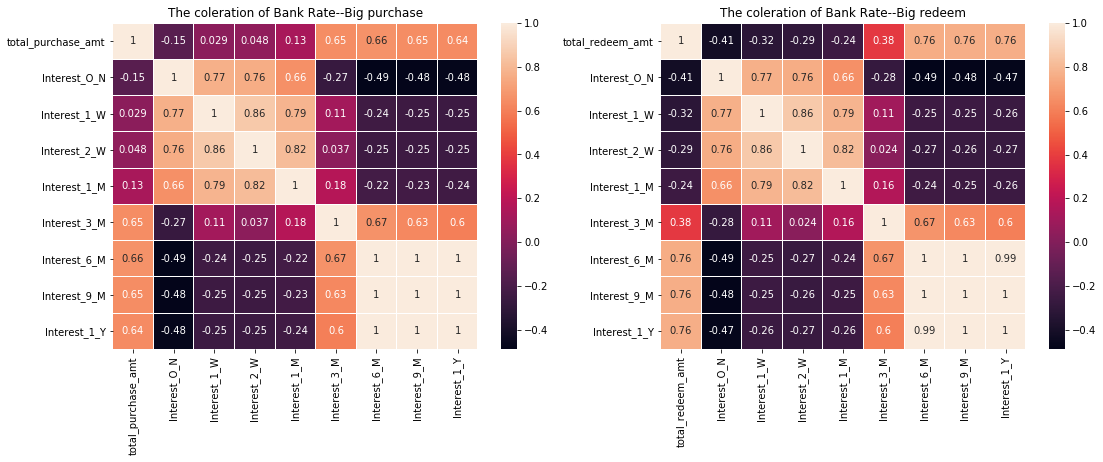

In [191]:
# 小额交易量
plt.figure(figsize=(18, 6))
plt.subplot(1,2,1)
plt.title("The coleration of Bank Rate--Small purchase")
bank_samll_purchase_day = pd.merge(bank[['last_date'] + bank_features], small_purchase, 
                left_on='last_date', right_on='date')[['total_purchase_amt'] + bank_features]
sns.heatmap(bank_samll_purchase_day.corr(), linewidths=0.05, annot=True)

plt.subplot(1,2,2)
plt.title("The coleration of Bank Rate--Small redeem")
bank_samll_redeem_day = pd.merge(bank[['last_date'] + bank_features], small_redeem, 
                left_on='last_date', right_on='date')[['total_redeem_amt'] + bank_features]
sns.heatmap(bank_samll_redeem_day.corr(), linewidths=0.05, annot=True)  



# 大额交易量
plt.figure(figsize=(18, 6))
plt.subplot(1,2,1)
plt.title("The coleration of Bank Rate--Big purchase")
bank_big_purchase_day = pd.merge(bank[['last_date'] + bank_features], big_purchase, 
                left_on='last_date', right_on='date')[['total_purchase_amt'] + bank_features]
sns.heatmap(bank_big_purchase_day.corr(), linewidths=0.05, annot=True)  

plt.subplot(1,2,2)
plt.title("The coleration of Bank Rate--Big redeem")
bank_big_redeem_day = pd.merge(bank[['last_date']+ bank_features], big_redeem, 
                left_on='last_date', right_on='date')[['total_redeem_amt'] + bank_features]
sns.heatmap(bank_big_redeem_day.corr(), linewidths=0.05, annot=True)  

#### 前一天的支付宝利率 与 大额小额交易量数据的相关系数图

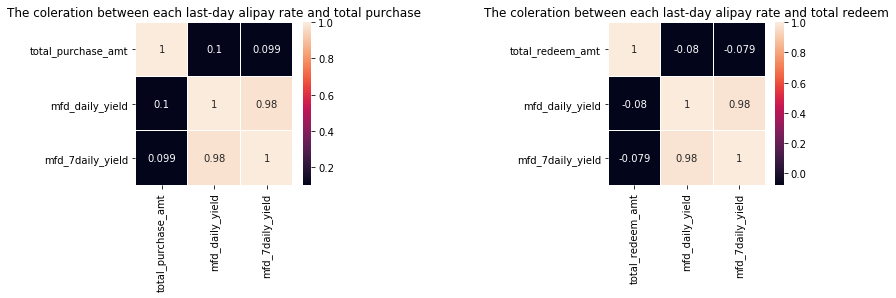

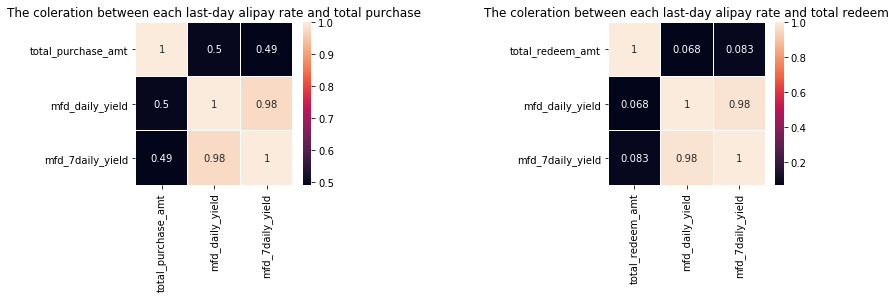

In [193]:
# 小额交易量
plt.figure(figsize=(12, 3))
plt.subplot(1,3,1)
plt.title("The coleration between each last-day alipay rate and total purchase")
# 分别对照 bank 的 last_date，total_balance 的 date 进行数据合并
alipay_small_purchase_day = pd.merge(share[['last_date'] + share_features], small_purchase, 
                left_on='last_date', right_on='date')[['total_purchase_amt'] + share_features]
sns.heatmap(alipay_small_purchase_day.corr(), linewidths=0.05, annot=True) 

plt.subplot(1,3,3)
plt.title("The coleration between each last-day alipay rate and total redeem")
alipay_small_redeem_day = pd.merge(share[['last_date'] + share_features], small_redeem, 
                left_on='last_date', right_on='date')[['total_redeem_amt'] + share_features]
sns.heatmap(alipay_small_redeem_day.corr(), linewidths=0.05, annot=True)  



# 大额交易量
plt.figure(figsize=(12, 3))
plt.subplot(1,3,1)
plt.title("The coleration between each last-day alipay rate and total purchase")
# 分别对照 bank 的 last_date，total_balance 的 date 进行数据合并
alipay_big_purchase_day = pd.merge(share[['last_date'] + share_features], big_purchase, 
                left_on='last_date', right_on='date')[['total_purchase_amt'] + share_features]
sns.heatmap(alipay_big_purchase_day.corr(), linewidths=0.05, annot=True) 

plt.subplot(1,3,3)
plt.title("The coleration between each last-day alipay rate and total redeem")
alipay_big_redeem_day = pd.merge(share[['last_date'] + share_features], big_redeem, 
                left_on='last_date', right_on='date')[['total_redeem_amt'] + share_features]
sns.heatmap(alipay_big_redeem_day.corr(), linewidths=0.05, annot=True)  

#### 前一周的银行利率 与 大额小额交易量数据的相关系数图

In [201]:
small_purchase['week'] = small_purchase['date'].dt.week
small_redeem['week'] = small_redeem['date'].dt.week
big_purchase['week'] = big_purchase['date'].dt.week
big_redeem['week'] = big_redeem['date'].dt.week

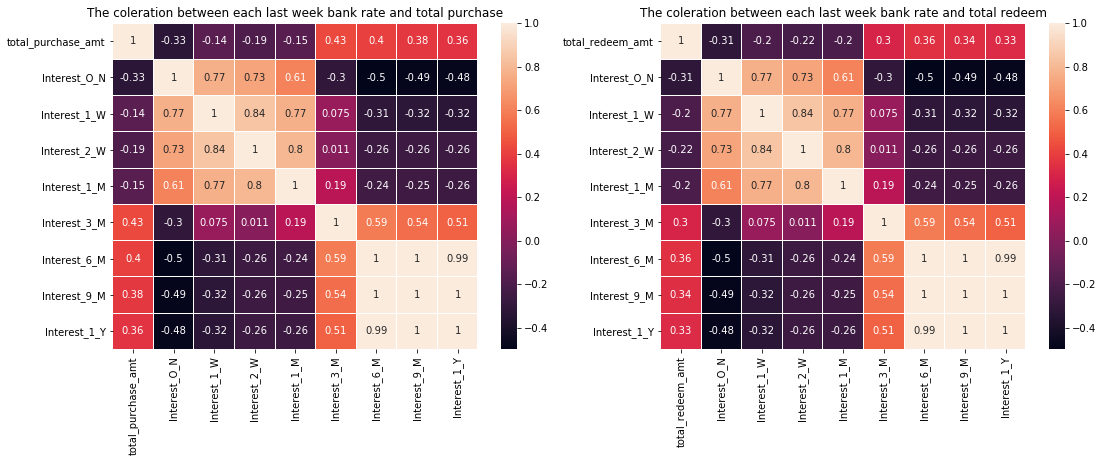

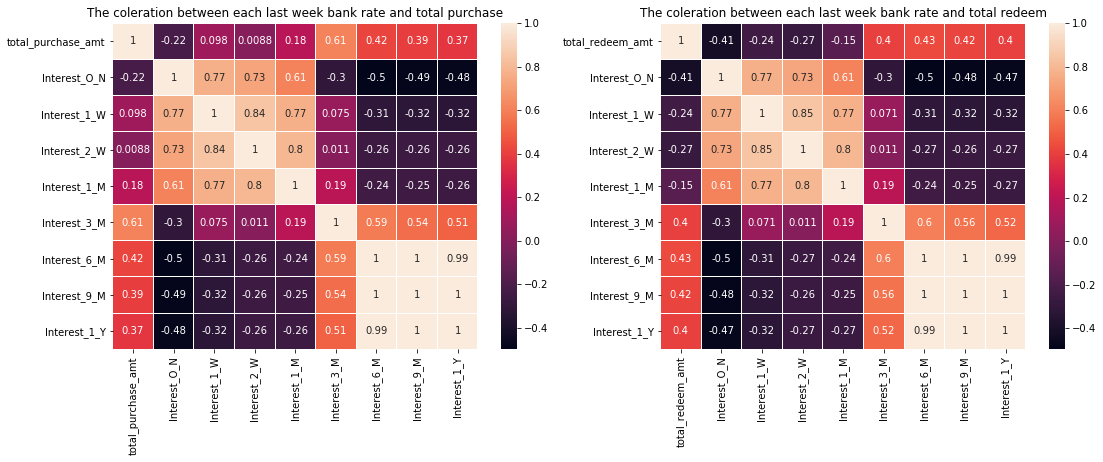

In [204]:
# 小额交易量
plt.figure(figsize=(18, 6))
plt.subplot(1,2,1)
plt.title("The coleration between each last week bank rate and total purchase")
bank_small_purchase_week = pd.merge(bank[['last_week','weekday'] + bank_features], small_purchase, 
                              left_on=['last_week','weekday'], right_on=['week','weekday'])[['total_purchase_amt'] + bank_features]
sns.heatmap(bank_small_purchase_week.corr(), linewidths=0.05, annot=True) 

plt.subplot(1,2,2)
plt.title("The coleration between each last week bank rate and total redeem")
bank_small_redeem_week = pd.merge(bank[['last_week','weekday'] + bank_features], small_redeem, 
                            left_on=['last_week','weekday'], right_on=['week','weekday'])[['total_redeem_amt'] + bank_features]
sns.heatmap(bank_small_redeem_week.corr(), linewidths=0.05, annot=True) 



# 大额交易量
plt.figure(figsize=(18, 6))
plt.subplot(1,2,1)
plt.title("The coleration between each last week bank rate and total purchase")
bank_big_purchase_week = pd.merge(bank[['last_week','weekday'] + bank_features], big_purchase, 
                              left_on=['last_week','weekday'], right_on=['week','weekday'])[['total_purchase_amt'] + bank_features]
sns.heatmap(bank_big_purchase_week.corr(), linewidths=0.05, annot=True) 

plt.subplot(1,2,2)
plt.title("The coleration between each last week bank rate and total redeem")
bank_big_redeem_week = pd.merge(bank[['last_week','weekday'] + bank_features], big_redeem, 
                            left_on=['last_week','weekday'], right_on=['week','weekday'])[['total_redeem_amt'] + bank_features]
sns.heatmap(bank_big_redeem_week.corr(), linewidths=0.05, annot=True) 

#### 前一周的支付宝利率 与 大额小额交易量数据的相关系数图

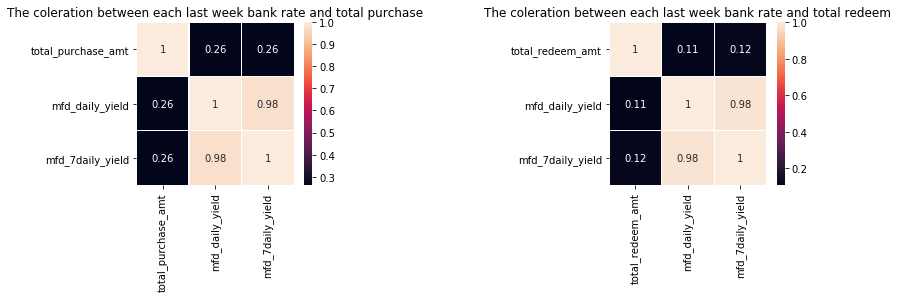

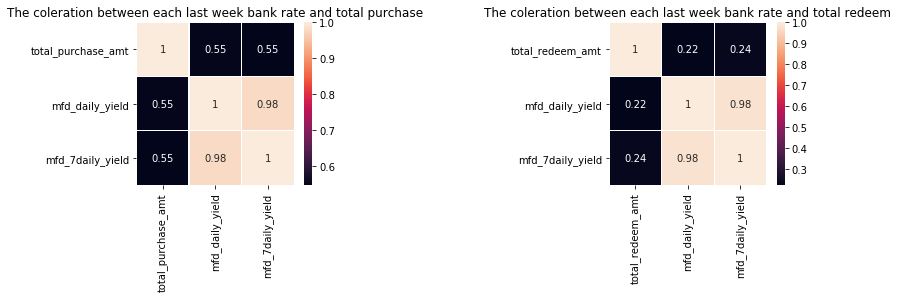

In [205]:
# 小额交易量
plt.figure(figsize=(12, 3))
plt.subplot(1,3,1)
plt.title("The coleration between each last week bank rate and total purchase")
alipay_small_purchase_week = pd.merge(share[['last_week','weekday'] + share_features], small_purchase, 
                              left_on=['last_week','weekday'], right_on=['week','weekday'])[['total_purchase_amt'] + share_features]
sns.heatmap(alipay_small_purchase_week.corr(), linewidths=0.05, annot=True) 

plt.subplot(1,3,3)
plt.title("The coleration between each last week bank rate and total redeem")
alipay_small_redeem_week = pd.merge(share[['last_week','weekday'] + share_features], small_redeem, 
                            left_on=['last_week','weekday'], right_on=['week','weekday'])[['total_redeem_amt'] + share_features]
sns.heatmap(alipay_small_redeem_week.corr(), linewidths=0.05, annot=True) 



# 大额交易量
plt.figure(figsize=(12, 3))
plt.subplot(1,3,1)
plt.title("The coleration between each last week bank rate and total purchase")
alipay_big_purchase_week = pd.merge(share[['last_week','weekday'] + share_features], big_purchase, 
                              left_on=['last_week','weekday'], right_on=['week','weekday'])[['total_purchase_amt'] + share_features]
sns.heatmap(alipay_big_purchase_week.corr(), linewidths=0.05, annot=True) 

plt.subplot(1,3,3)
plt.title("The coleration between each last week bank rate and total redeem")
alipay_big_redeem_week = pd.merge(share[['last_week','weekday'] + share_features], big_redeem, 
                            left_on=['last_week','weekday'], right_on=['week','weekday'])[['total_redeem_amt'] + share_features]
sns.heatmap(alipay_big_redeem_week.corr(), linewidths=0.05, annot=True) 

Text(0, 0.5, 'Rate')

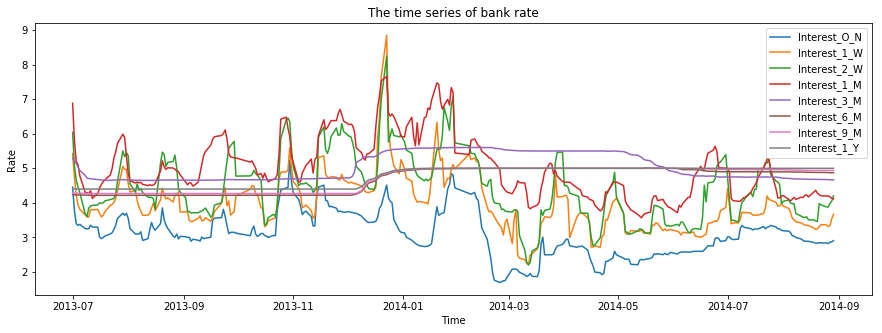

In [60]:
# 画出银行利率的时序图

plt.figure(figsize=(15,5))
for i in bank_features:
    plt.plot(bank['date'], bank[[i]] ,label=i)
plt.legend()
plt.title("The time series of bank rate")
plt.xlabel("Time")
plt.ylabel("Rate")

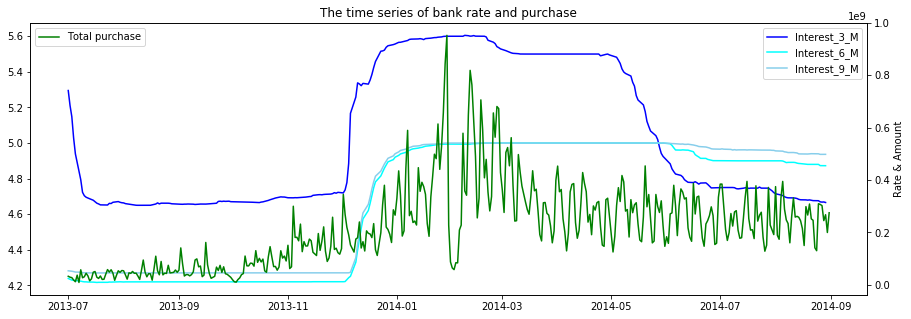

In [61]:
# 画出部分银行利率与购买量的时序图

fig,ax1 = plt.subplots(figsize=(15,5))
plt.plot(bank['date'], bank['Interest_3_M'],'b',label="Interest_3_M")
plt.plot(bank['date'], bank['Interest_6_M'],'cyan',label="Interest_6_M")
plt.plot(bank['date'], bank['Interest_9_M'],'skyblue',label="Interest_9_M")

plt.legend()

ax2=ax1.twinx()
plt.plot(total_balance['date'], total_balance['total_purchase_amt'],'g',label="Total purchase")

plt.legend(loc=2)
plt.title("The time series of bank rate and purchase")
plt.xlabel("Time")
plt.ylabel("Rate & Amount")
plt.show()


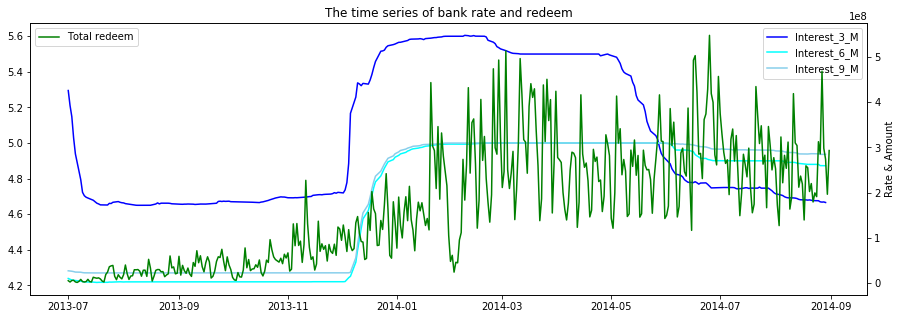

In [62]:
# 画出部分银行利率与赎回量的时序图

fig,ax1 = plt.subplots(figsize=(15,5))
plt.plot(bank['date'], bank['Interest_3_M'],'b',label="Interest_3_M")
plt.plot(bank['date'], bank['Interest_6_M'],'cyan',label="Interest_6_M")
plt.plot(bank['date'], bank['Interest_9_M'],'skyblue',label="Interest_9_M")

plt.legend()

ax2=ax1.twinx()
plt.plot(total_balance['date'], total_balance['total_redeem_amt'],'g',label="Total redeem")

plt.legend(loc=2)
plt.title("The time series of bank rate and redeem")
plt.xlabel("Time")
plt.ylabel("Rate & Amount")

plt.show()


## The information for Share rate

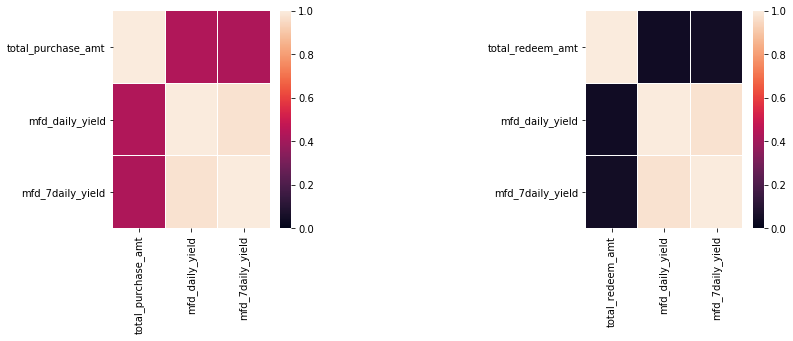

In [63]:
# 画出支付宝利率与标签的相关性图

share['last_date'] = share['date'] + datetime.timedelta(days=1)
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
temp = pd.merge(share[['last_date']+share_features], total_balance, left_on='last_date', right_on='date')[['total_purchase_amt']+share_features]
sns.heatmap(temp.corr(), linewidths = 0.05, vmin = 0)  
plt.subplot(1,3,3)
temp = pd.merge(share[['last_date']+share_features], total_balance, left_on='last_date', right_on='date')[['total_redeem_amt']+share_features]
sns.heatmap(temp.corr(), linewidths = 0.05, vmin = 0)  

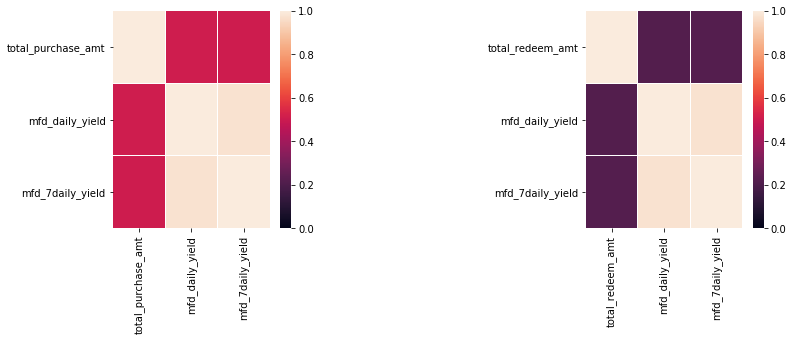

In [64]:
# 画出银行利率与标签的相关性图

share['last_week'] = share['week'] + 1
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
temp = pd.merge(share[['last_week','weekday']+share_features], total_balance, left_on=['last_week','weekday'], right_on=['week','weekday'])[['total_purchase_amt']+share_features]
sns.heatmap(temp.corr(), linewidths = 0.05, vmin = 0)  
plt.subplot(1,3,3)
temp = pd.merge(share[['last_week','weekday']+share_features], total_balance, left_on=['last_week','weekday'], right_on=['week','weekday'])[['total_redeem_amt']+share_features]
sns.heatmap(temp.corr(), linewidths = 0.05, vmin = 0) 

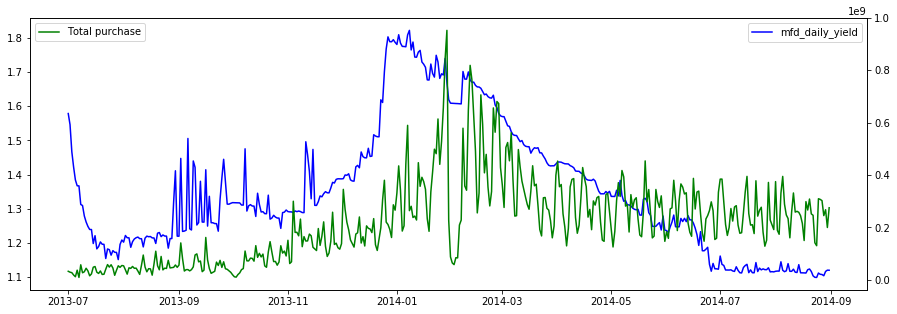

In [65]:
# 画出支付宝利率与购买量的时序图

fig,ax1 = plt.subplots(figsize=(15,5))
for i in share_features:
    plt.plot(share['date'], share[i],'b',label=i)
    break
plt.legend()
ax2=ax1.twinx()
plt.plot(total_balance['date'], total_balance['total_purchase_amt'],'g',label="Total purchase")
plt.legend(loc=2)
plt.show()

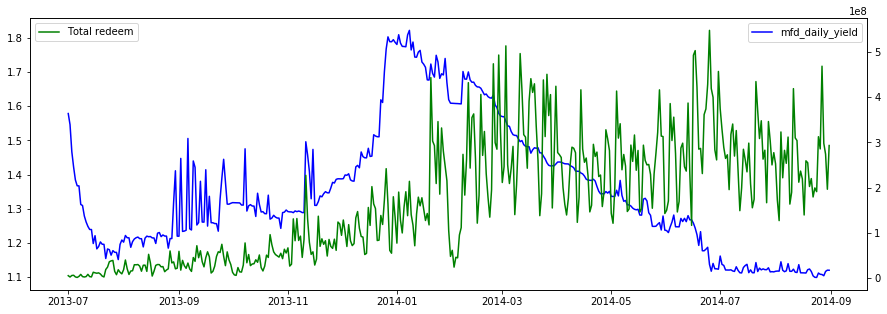

In [66]:
# 画出支付宝利率与赎回量的时序图

fig,ax1 = plt.subplots(figsize=(15,5))
for i in share_features:
    plt.plot(share['date'], share[i],'b',label=i)
    break
plt.legend()
ax2=ax1.twinx()
plt.plot(total_balance['date'], total_balance['total_redeem_amt'],'g',label="Total redeem")
plt.legend(loc=2)
plt.show()

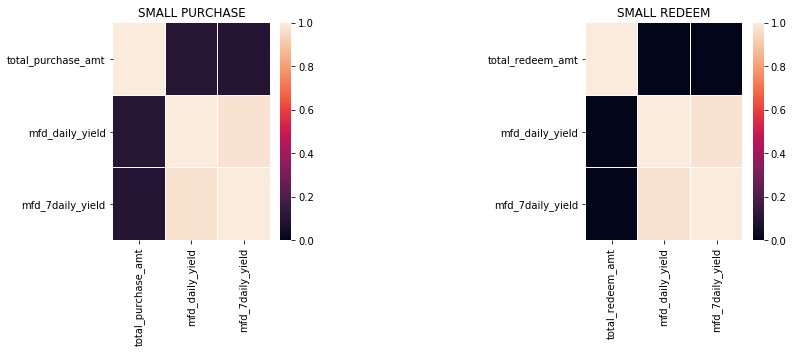

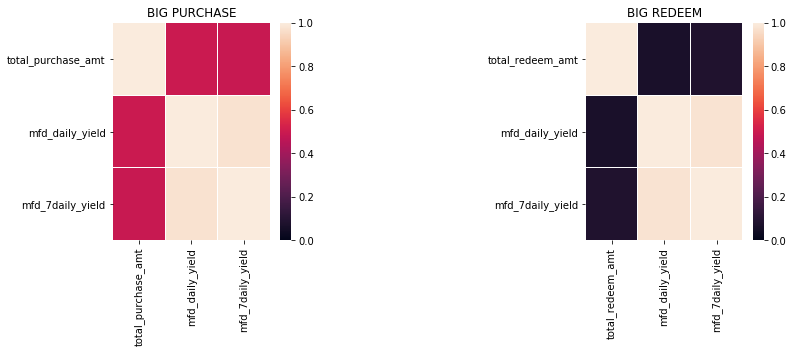

In [67]:
# 画出大额小额数据与支付宝利率的相关性图

share['last_date'] = share['date'] + datetime.timedelta(days=1)
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
temp = pd.merge(share[['last_date']+share_features], small_purchase, left_on='last_date', right_on='date')[['total_purchase_amt']+share_features]
sns.heatmap(temp.corr(), linewidths = 0.05, vmin=0)  
plt.title("SMALL PURCHASE")
plt.subplot(1,3,3)
plt.title("SMALL REDEEM")
temp = pd.merge(share[['last_date']+share_features], small_redeem, left_on='last_date', right_on='date')[['total_redeem_amt']+share_features]
sns.heatmap(temp.corr(), linewidths = 0.05, vmin=0)  

share['last_date'] = share['date'] + datetime.timedelta(days=1)
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.title("BIG PURCHASE")
temp = pd.merge(share[['last_date']+share_features], big_purchase, left_on='last_date', right_on='date')[['total_purchase_amt']+share_features]
sns.heatmap(temp.corr(), linewidths = 0.05, vmin=0)  
plt.subplot(1,3,3)
plt.title("BIG REDEEM")
temp = pd.merge(share[['last_date']+share_features], big_redeem, left_on='last_date', right_on='date')[['total_redeem_amt']+share_features]
sns.heatmap(temp.corr(), linewidths = 0.05, vmin=0)  

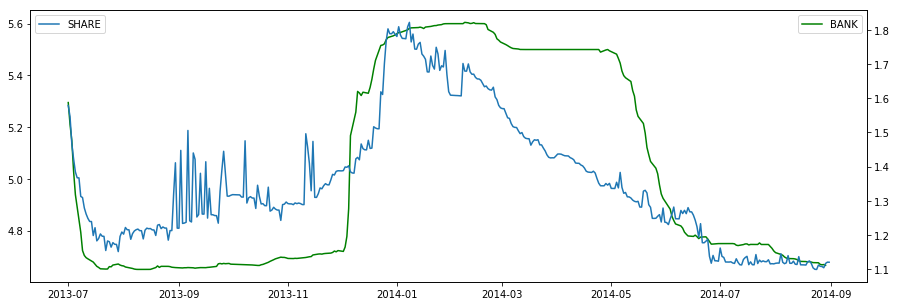

In [68]:
# 画出银行利率与支付宝利率的时序图

fig,ax1 = plt.subplots(figsize=(15,5))
plt.plot(bank['date'], bank['Interest_3_M'],c='g',label= 'BANK')

plt.legend()
ax2=ax1.twinx()
plt.plot(share['date'], share['mfd_daily_yield'],label='SHARE')
plt.legend(loc=2)
plt.show()

It seems that:

1. The influence of share is more likely to act on Purchase
2. The influence of bank rate is more likely to act on Redeem
1. The influence of share rate is for short
2. The influence of bank rate is for long


#### based on above analysis, we can simply find three features:

1. the weekday
2. is it weekend
3. is it holidy
5. the distance from the start of week(monday)
6. the distance from the end of week(sunday)
7. the distance from the holiday centre(centre of QingMing DuanWu Labour ZhongQiu)
8. the distance from the start of month
9. the distance from the end of month
10. the mean/max/min value of the same week in last month
11. the value in last day of last month